Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Loss: 0.05212292820215225, Validation Loss: 0.06791377067565918
Epoch 2, Loss: 0.0551203191280365, Validation Loss: 0.06593161821365356
Epoch 3, Loss: 0.05462892726063728, Validation Loss: 0.05900309234857559
Epoch 4, Loss: 0.03379352018237114, Validation Loss: 0.02525937184691429
Epoch 5, Loss: 0.012490883469581604, Validation Loss: 0.011024784296751022
Epoch 6, Loss: 0.004595836158841848, Validation Loss: 0.004603038541972637
Epoch 7, Loss: 0.001824612496420741, Validation Loss: 0.0014891125028952956
Epoch 8, Loss: 0.0018289919244125485, Validation Loss: 0.0011852355673909187
Epoch 9, Loss: 0.0012662425870075822, Validation Loss: 0.0009494868572801352
Epoch 10, Loss: 0.0010115945478901267, Validation Loss: 0.0006565203657373786
Epoch 11, Loss: 0.0007794554112479091, Validation Loss: 0.00043002390884794295
Epoch 12, Loss: 0.0005599469295702875, Validation Loss: 0.000250252487603575
Epoch 13, Loss: 0.0005021580145694315, Validation Loss: 0.00013673493231181055
Epoch 14, Loss: 

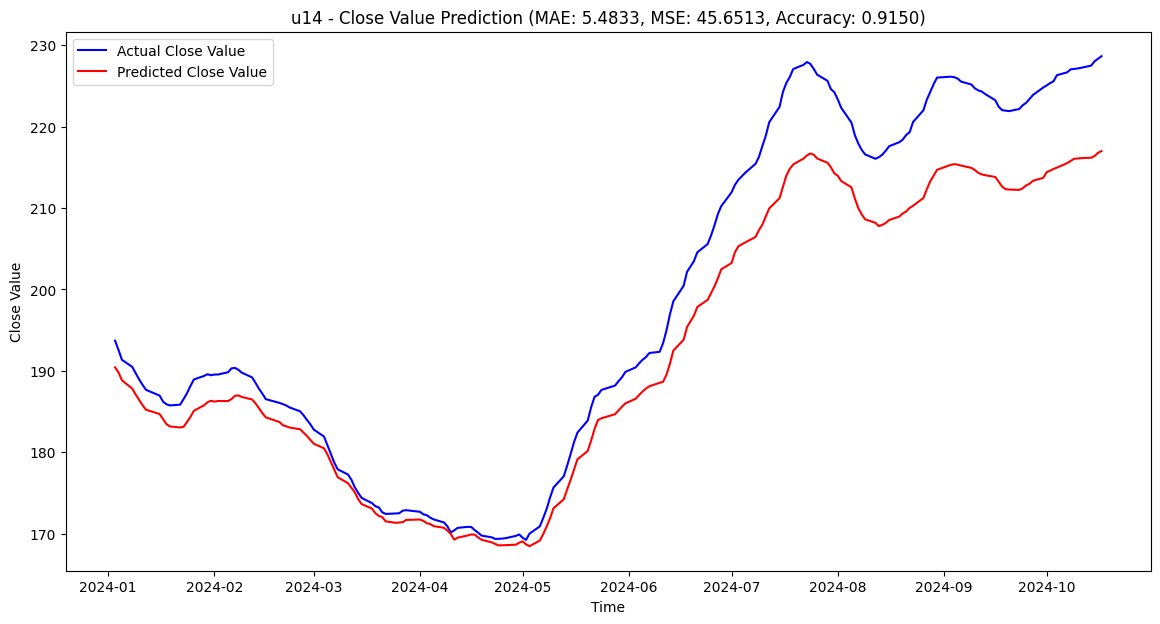

Predictions saved to u14_predictions3.csv
d142 - MAE: 0.9139, MSE: 3.4822
d142 - Buy/Sell Accuracy: 0.4908


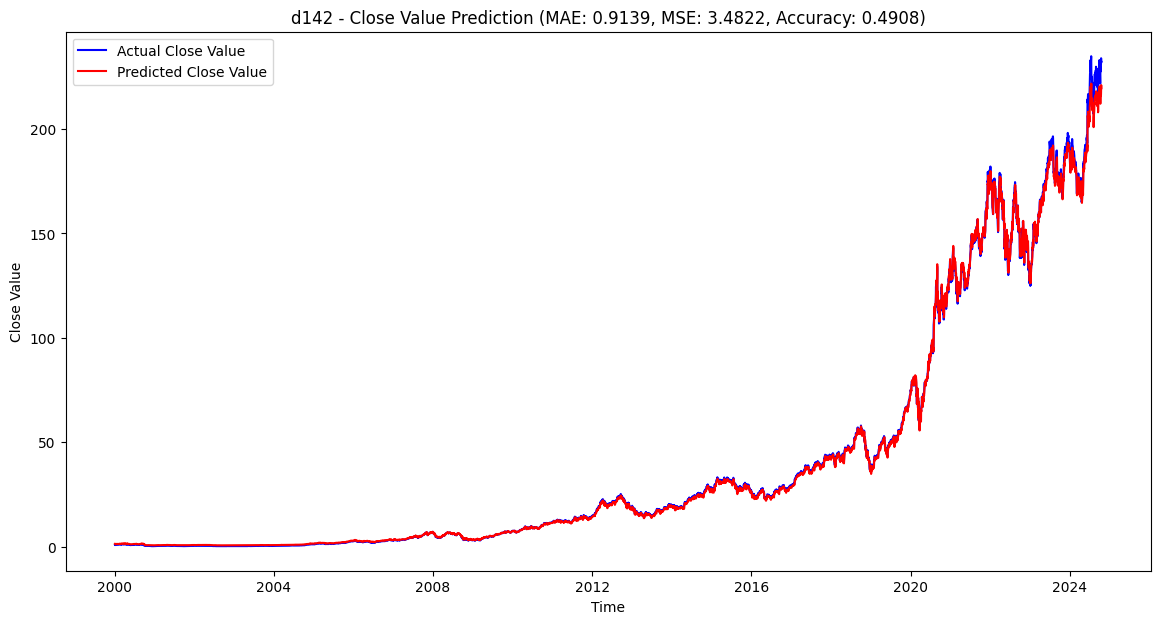

Predictions saved to d142_predictions3.csv


In [20]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Load the training dataset
data = pd.read_csv('t14.csv')

# Use only 'Close' column as the target and features for LSTM model
data['timestamp'] = pd.to_datetime(data['Date'])
data.set_index('timestamp', inplace=True)
data.sort_index(inplace=True)
close_prices = data[['Close']]

# Normalizing the training data
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(close_prices)
data_scaled_df = pd.DataFrame(scaled_values, columns=close_prices.columns, index=close_prices.index)

# Sequence function
def create_sequence(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i - window_size:i].values)
        y.append(data.iloc[i]['Close'])
    return np.array(X), np.array(y)

# Create sequences for training
window_size = 1
X, y = create_sequence(data_scaled_df, window_size)

# Split data (randomly)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Make y a column vector
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Load data in batches
batch_size = 512
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=1, num_layers=4):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

input_dim = X_train.shape[2]
model = LSTMModel(input_dim=input_dim, output_dim=1).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler for adaptive learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training with early stopping
num_epochs = 100
early_stop_patience = 10
best_loss = float('inf')
patience = 0
best_model = None

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test.to(device))
        val_loss = criterion(val_outputs, y_test.to(device))

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

    # Step the scheduler with the validation loss
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience = 0
        best_model = model.state_dict()
    else:
        patience += 1
        print("current patience:", patience)

        if patience >= early_stop_patience:
            print("Early stopping")
            break

# Load the best model
model.load_state_dict(best_model)

# Function to predict, evaluate, plot, and save to CSV
def predict_evaluate_plot_save(undata_filename, model, scaler, window_size, title_prefix):
    # Load the prediction dataset
    undata = pd.read_csv(undata_filename)
    undata['timestamp'] = pd.to_datetime(undata['Date'])
    undata.set_index('timestamp', inplace=True)
    undata.sort_index(inplace=True)
    close_prices_undata = undata[['Close']]

    # Normalizing the prediction dataset
    scaled_values_undata = scaler.transform(close_prices_undata)
    undata_scaled_df = pd.DataFrame(scaled_values_undata, columns=close_prices_undata.columns, index=close_prices_undata.index)

    # Create sequences for prediction
    X_undata, y_undata = create_sequence(undata_scaled_df, window_size)
    X_undata = torch.tensor(X_undata, dtype=torch.float32).to(device)

    # Predictions for the new dataset
    model.eval()
    with torch.no_grad():
        predictions_undata = model(X_undata).cpu().numpy()

    # Inverse transform the predictions and actual values
    y_undata_combined = np.concatenate((y_undata.reshape(-1, 1), np.zeros((y_undata.shape[0], undata_scaled_df.shape[1] - 1))), axis=1)
    y_undata_rescaled = scaler.inverse_transform(y_undata_combined)[:, 0]

    predictions_undata_combined = np.concatenate((predictions_undata, np.zeros((predictions_undata.shape[0], undata_scaled_df.shape[1] - 1))), axis=1)
    predictions_undata_rescaled = scaler.inverse_transform(predictions_undata_combined)[:, 0]

    # Ensure lengths match for plotting and saving
    min_length = min(len(y_undata_rescaled), len(predictions_undata_rescaled))
    y_undata_rescaled = y_undata_rescaled[:min_length]
    predictions_undata_rescaled = predictions_undata_rescaled[:min_length]

    # Calculate MAE and MSE
    mae_undata = mean_absolute_error(y_undata_rescaled, predictions_undata_rescaled)
    mse_undata = mean_squared_error(y_undata_rescaled, predictions_undata_rescaled)
    print(f"{title_prefix} - MAE: {mae_undata:.4f}, MSE: {mse_undata:.4f}")

    # Create 'buyorsell' labels based on predicted price movements
    actual_buyorsell = []
    predicted_buyorsell = []
    for i in range(len(predictions_undata_rescaled) - 1):
        if y_undata_rescaled[i+1] > y_undata_rescaled[i]:
            actual_buyorsell.append('buy')
        else:
            actual_buyorsell.append('sell')

        if predictions_undata_rescaled[i+1] > predictions_undata_rescaled[i]:
            predicted_buyorsell.append('buy')
        else:
            predicted_buyorsell.append('sell')

    # Assign the last label for buy/sell to avoid exceeding range
    actual_buyorsell.append('buy' if y_undata_rescaled[-1] > y_undata_rescaled[-2] else 'sell')
    predicted_buyorsell.append('buy' if predictions_undata_rescaled[-1] > predictions_undata_rescaled[-2] else 'sell')

    # Calculate accuracy of 'buyorsell' predictions
    actual_buyorsell = np.array(actual_buyorsell)
    predicted_buyorsell = np.array(predicted_buyorsell)
    accuracy = accuracy_score(actual_buyorsell, predicted_buyorsell)
    print(f"{title_prefix} - Buy/Sell Accuracy: {accuracy:.4f}")

    # Plot
    plt.figure(figsize=(14, 7))
    plt.plot(undata.index[window_size:window_size + min_length], y_undata_rescaled, color='blue', label='Actual Close Value')
    plt.plot(undata.index[window_size:window_size + min_length], predictions_undata_rescaled, color='red', label='Predicted Close Value')
    plt.title(f'{title_prefix} - Close Value Prediction (MAE: {mae_undata:.4f}, MSE: {mse_undata:.4f}, Accuracy: {accuracy:.4f})')
    plt.xlabel('Time')
    plt.ylabel('Close Value')
    plt.legend()
    plt.show()

    # Save the predicted results to CSV
    undata_result = undata.iloc[window_size:window_size + min_length].copy()  # Align lengths properly
    undata_result['Predicted_Close'] = predictions_undata_rescaled  # Assign predictions
    undata_result['Predicted_BuyOrSell'] = predicted_buyorsell  # Assign predicted buy/sell labels
    undata_result.to_csv(f"{title_prefix}_predictions3.csv", index=True)
    print(f"Predictions saved to {title_prefix}_predictions3.csv")

# Apply model to 'u14.csv'
predict_evaluate_plot_save('u14.csv', model, scaler, window_size, title_prefix='u14')

# Apply model to 'd142.csv'
predict_evaluate_plot_save('data.csv', model, scaler, window_size, title_prefix='d142')


# buy one stock at once

Date: 2024-01-04 00:00:00, Cash: 10000.00, Stocks: 0, Total Value: 10000.00
Date: 2024-01-05 00:00:00, Cash: 10000.00, Stocks: 0, Total Value: 10000.00
Date: 2024-01-08 00:00:00, Cash: 10000.00, Stocks: 0, Total Value: 10000.00
Date: 2024-01-09 00:00:00, Cash: 10000.00, Stocks: 0, Total Value: 10000.00
Date: 2024-01-10 00:00:00, Cash: 10000.00, Stocks: 0, Total Value: 10000.00
Date: 2024-01-11 00:00:00, Cash: 10000.00, Stocks: 0, Total Value: 10000.00
Date: 2024-01-12 00:00:00, Cash: 10000.00, Stocks: 0, Total Value: 10000.00
Date: 2024-01-16 00:00:00, Cash: 10000.00, Stocks: 0, Total Value: 10000.00
Date: 2024-01-17 00:00:00, Cash: 10000.00, Stocks: 0, Total Value: 10000.00
Date: 2024-01-18 00:00:00, Cash: 10000.00, Stocks: 0, Total Value: 10000.00
Date: 2024-01-19 00:00:00, Cash: 10000.00, Stocks: 0, Total Value: 10000.00
Date: 2024-01-22 00:00:00, Cash: 10000.00, Stocks: 0, Total Value: 10000.00
Date: 2024-01-23 00:00:00, Cash: 9804.82, Stocks: 1, Total Value: 10000.00
Date: 2024-01

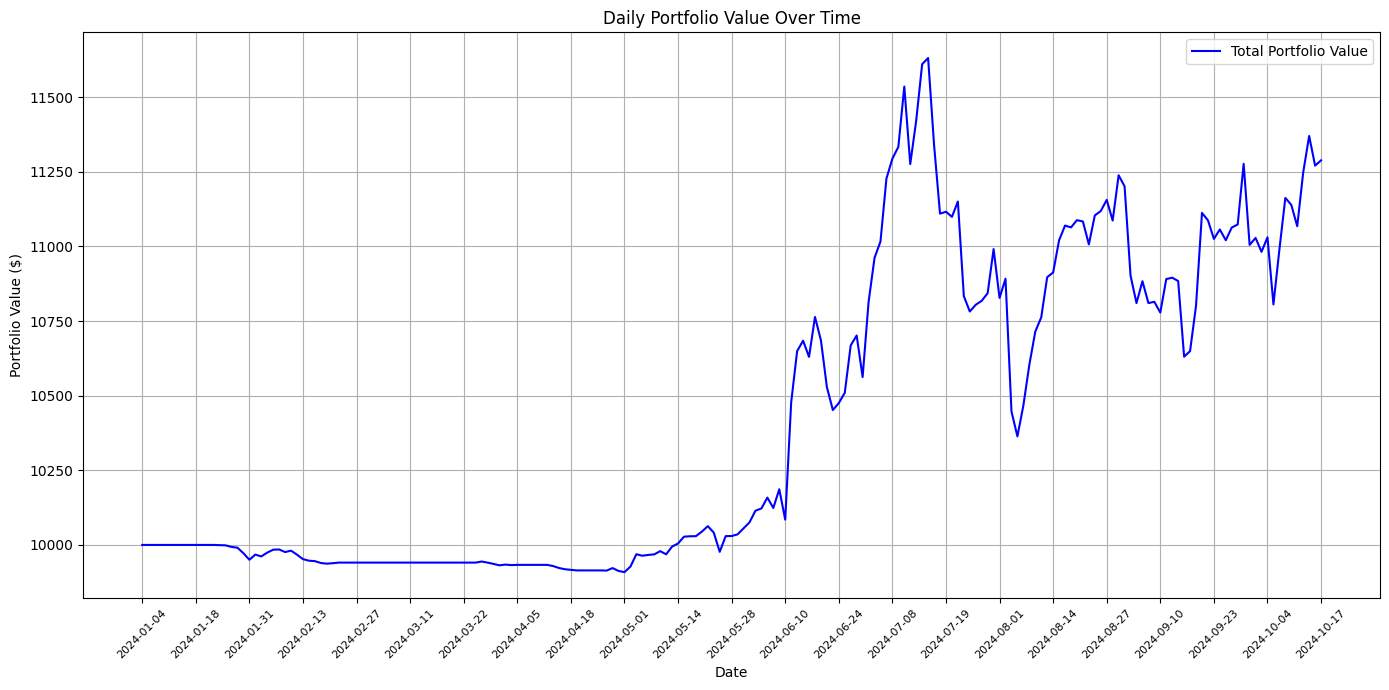


Initial Cash: $10000.00
Final Portfolio Value: $11288.61
Total Profit or Loss: $1288.61


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the prediction dataset and original data
predictions = pd.read_csv("u14_predictions.csv")
original_data = pd.read_csv("data.csv")

# Ensure both datasets have the same index for consistent calculations
predictions['timestamp'] = pd.to_datetime(predictions['Date'])
original_data['timestamp'] = pd.to_datetime(original_data['Date'])
merged = pd.merge(predictions[['timestamp', 'Predicted_BuyOrSell']], original_data[['timestamp', 'Close']], on='timestamp')
merged.sort_values(by='timestamp', inplace=True)

# Initial conditions
initial_cash = 10000.0
cash = initial_cash
stocks = 0

# DataFrame to track daily account changes
account_changes = []

# Simulate trading
for index, row in merged.iterrows():
    action = row['Predicted_BuyOrSell']
    price = row['Close']

    if action == 'buy' and cash >= price:
        # Buy 1 stock if we have enough cash
        cash -= price
        stocks += 1
    elif action == 'sell' and stocks > 0:
        # Sell 1 stock if we have any holdings
        cash += price
        stocks -= 1

    # Record daily account value
    total_value = cash + (stocks * price)
    account_changes.append({'Date': row['timestamp'], 'Cash': cash, 'Stocks': stocks, 'Total Value': total_value})

    # Corrected print statement for daily account changes
    print(f"Date: {row['timestamp']}, Cash: {cash:.2f}, Stocks: {stocks}, Total Value: {total_value:.2f}")

# Create DataFrame from account changes
account_df = pd.DataFrame(account_changes)

# Format the Date for better readability
account_df['Date'] = account_df['Date'].dt.strftime('%Y-%m-%d')

# Print daily account changes with expanded date
print("Daily Account Changes:")
print(account_df)

# Plot daily account value changes with more x-axis ticks for better visibility
plt.figure(figsize=(14, 7))
plt.plot(account_df['Date'], account_df['Total Value'], label='Total Portfolio Value', color='blue')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Daily Portfolio Value Over Time')
plt.xticks(rotation=45, fontsize=8)  # Rotate the x-axis labels for better readability and expand tick size
plt.xticks(ticks=range(0, len(account_df), max(1, len(account_df)//20)), rotation=45)  # Show more ticks, but not overcrowded
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final earnings calculation
final_value = account_df.iloc[-1]['Total Value']
profit_or_loss = final_value - initial_cash

# Print final earnings
print(f"\nInitial Cash: ${initial_cash:.2f}")
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Profit or Loss: ${profit_or_loss:.2f}")


#   All in type

Date: 2024-01-04 00:00:00, Cash: 100000.00, Stocks: 0, Total Value: 100000.00
Date: 2024-01-05 00:00:00, Cash: 100000.00, Stocks: 0, Total Value: 100000.00
Date: 2024-01-08 00:00:00, Cash: 100000.00, Stocks: 0, Total Value: 100000.00
Date: 2024-01-09 00:00:00, Cash: 100000.00, Stocks: 0, Total Value: 100000.00
Date: 2024-01-10 00:00:00, Cash: 100000.00, Stocks: 0, Total Value: 100000.00
Date: 2024-01-11 00:00:00, Cash: 100000.00, Stocks: 0, Total Value: 100000.00
Date: 2024-01-12 00:00:00, Cash: 100000.00, Stocks: 0, Total Value: 100000.00
Date: 2024-01-16 00:00:00, Cash: 100000.00, Stocks: 0, Total Value: 100000.00
Date: 2024-01-17 00:00:00, Cash: 100000.00, Stocks: 0, Total Value: 100000.00
Date: 2024-01-18 00:00:00, Cash: 100000.00, Stocks: 0, Total Value: 100000.00
Date: 2024-01-19 00:00:00, Cash: 100000.00, Stocks: 0, Total Value: 100000.00
Date: 2024-01-22 00:00:00, Cash: 100000.00, Stocks: 0, Total Value: 100000.00
Date: 2024-01-23 00:00:00, Cash: 67.84, Stocks: 512.0, Total Val

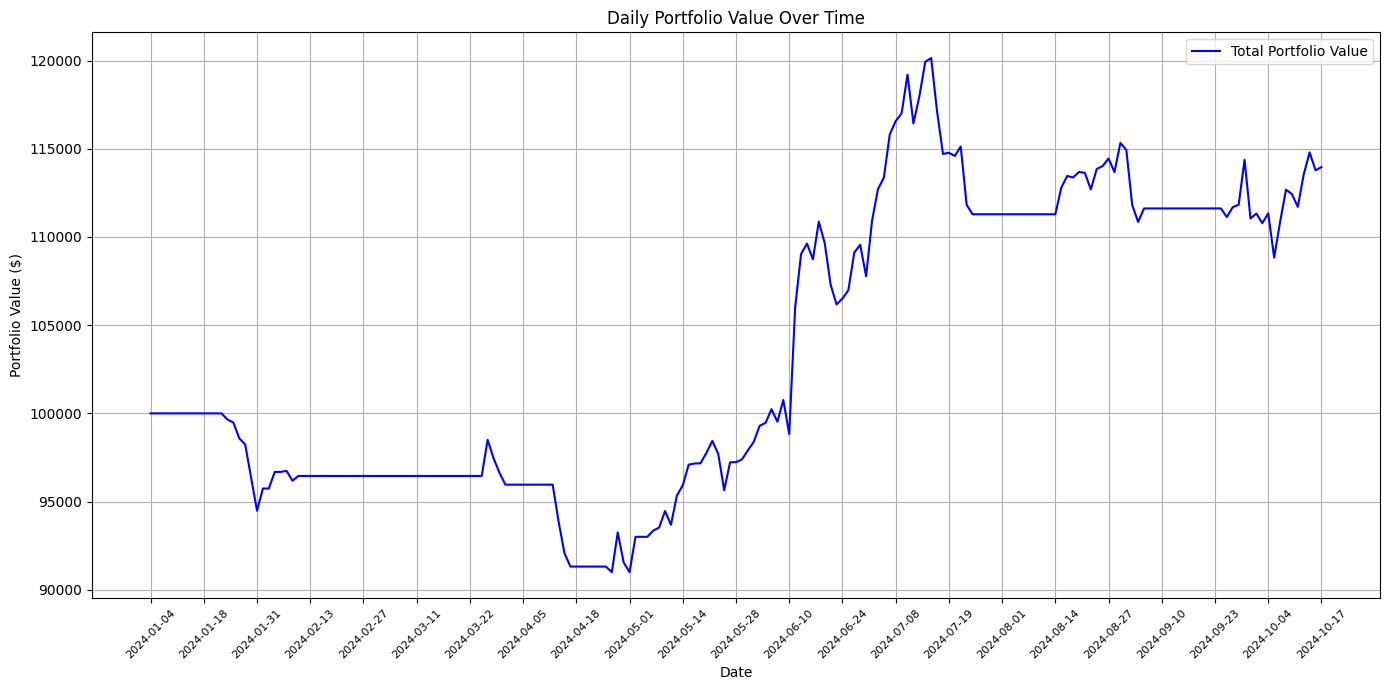


Initial Cash: $100000.00
Final Portfolio Value: $113958.91
Total Profit or Loss: $13958.91


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the prediction dataset and original data
predictions = pd.read_csv("u14_predictions.csv")
original_data = pd.read_csv("data.csv")

# Ensure both datasets have the same index for consistent calculations
predictions['timestamp'] = pd.to_datetime(predictions['Date'])
original_data['timestamp'] = pd.to_datetime(original_data['Date'])
merged = pd.merge(predictions[['timestamp', 'Predicted_BuyOrSell']], original_data[['timestamp', 'Close']], on='timestamp')
merged.sort_values(by='timestamp', inplace=True)

# Initial conditions
initial_cash = 100000.0
cash = initial_cash
stocks = 0

# DataFrame to track daily account changes
account_changes = []

# Simulate trading
for index, row in merged.iterrows():
    action = row['Predicted_BuyOrSell']
    price = row['Close']

    if action == 'buy' and cash >= price:
        # Buy as many stocks as we can afford with the available cash
        num_stocks_to_buy = cash // price
        cash -= num_stocks_to_buy * price
        stocks += num_stocks_to_buy
    elif action == 'sell' and stocks > 0:
        # Sell all stocks currently held
        cash += stocks * price
        stocks = 0

    # Record daily account value
    total_value = cash + (stocks * price)
    account_changes.append({'Date': row['timestamp'], 'Cash': cash, 'Stocks': stocks, 'Total Value': total_value})

    # Corrected print statement for daily account changes
    print(f"Date: {row['timestamp']}, Cash: {cash:.2f}, Stocks: {stocks}, Total Value: {total_value:.2f}")

# Create DataFrame from account changes
account_df = pd.DataFrame(account_changes)

# Format the Date for better readability
account_df['Date'] = account_df['Date'].dt.strftime('%Y-%m-%d')

# Print daily account changes with expanded date
print("\nDaily Account Changes:")
print(account_df)

# Plot daily account value changes with more x-axis ticks for better visibility
plt.figure(figsize=(14, 7))
plt.plot(account_df['Date'], account_df['Total Value'], label='Total Portfolio Value', color='blue')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Daily Portfolio Value Over Time')
plt.xticks(rotation=45, fontsize=8)  # Rotate the x-axis labels for better readability and expand tick size
plt.xticks(ticks=range(0, len(account_df), max(1, len(account_df) // 20)), rotation=45)  # Show more ticks, but not overcrowded
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final earnings calculation
final_value = account_df.iloc[-1]['Total Value']
profit_or_loss = final_value - initial_cash

# Print final earnings
print(f"\nInitial Cash: ${initial_cash:.2f}")
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Profit or Loss: ${profit_or_loss:.2f}")


# change to other moving average , like 7

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Loss: 0.0793260782957077, Validation Loss: 0.058625996112823486
Epoch 2, Loss: 0.07096374779939651, Validation Loss: 0.05665614828467369
Epoch 3, Loss: 0.08198896050453186, Validation Loss: 0.05220069736242294
Epoch 4, Loss: 0.03293297812342644, Validation Loss: 0.028775306418538094
Epoch 5, Loss: 0.007267409935593605, Validation Loss: 0.012895994819700718
Epoch 6, Loss: 0.0042142001911997795, Validation Loss: 0.00418098596855998
Epoch 7, Loss: 0.0017304844222962856, Validation Loss: 0.0010643044952303171
Epoch 8, Loss: 0.0003729403542820364, Validation Loss: 0.0007992159225977957
Epoch 9, Loss: 0.0012601334601640701, Validation Loss: 0.0007037388277240098
Epoch 10, Loss: 0.0003763516142498702, Validation Loss: 0.0005598488496616483
Epoch 11, Loss: 0.0009794289944693446, Validation Loss: 0.0003037163696717471
Epoch 12, Loss: 8.898158557713032e-05, Validation Loss: 0.00016420177416875958
Epoch 13, Loss: 0.00033962976885959506, Validation Loss: 0.0001392696867696941
Epoch 14, Lo

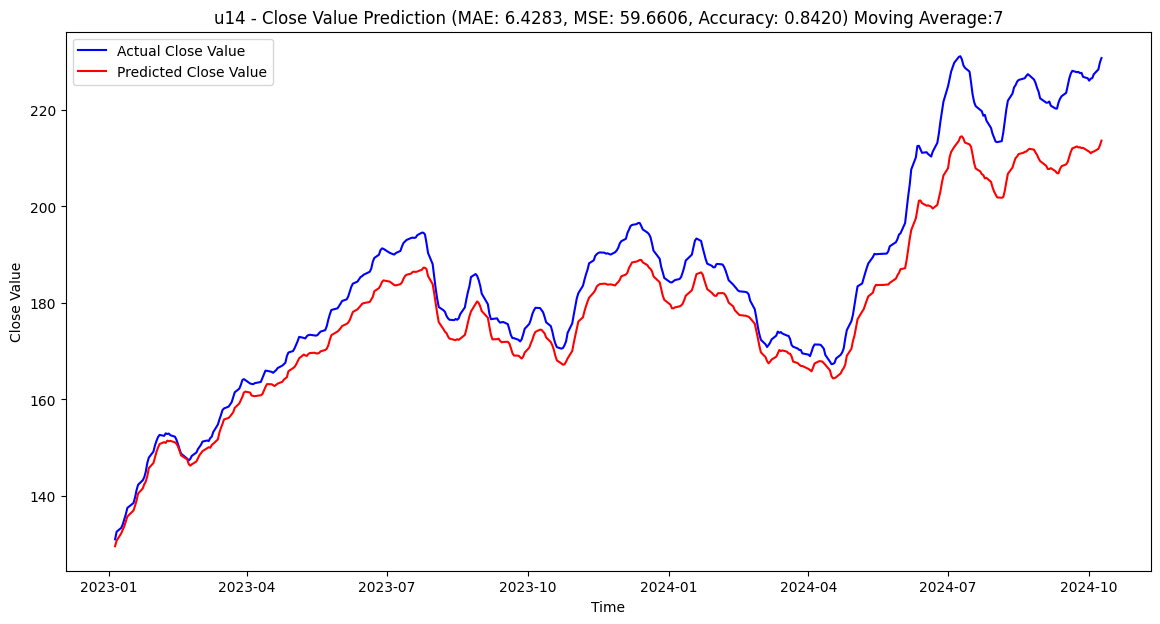

Predictions saved to u14_predictions7.csv
d142 - MAE: 1.0132, MSE: 4.9114
d142 - Buy/Sell Accuracy: 0.8421


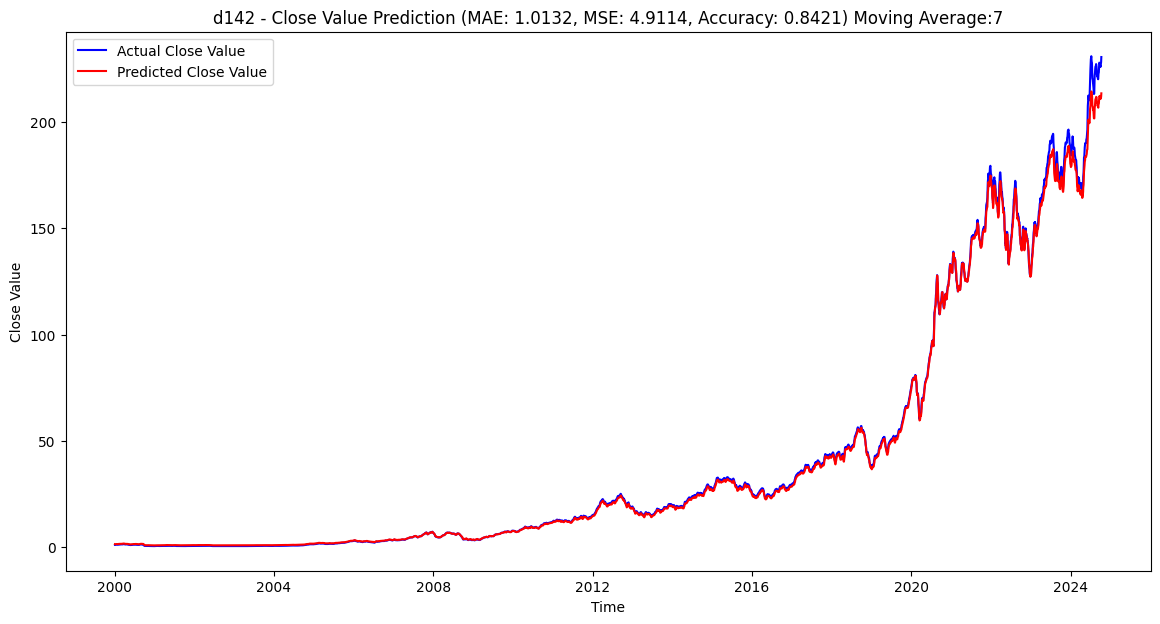

Predictions saved to d142_predictions7.csv


In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Load the training dataset
data = pd.read_csv('train.csv')

# Use only 'Close' column as the target and features for LSTM model
data['timestamp'] = pd.to_datetime(data['Date'])
data.set_index('timestamp', inplace=True)
data.sort_index(inplace=True)
close_prices = data[['Close']]

# Apply moving average to denoise the data
window_ma = 7  # You can adjust the window size as needed
close_prices_denoised = close_prices.rolling(window=window_ma).mean().dropna()

# Normalizing the training data
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(close_prices_denoised)
data_scaled_df = pd.DataFrame(scaled_values, columns=close_prices_denoised.columns, index=close_prices_denoised.index)

# Sequence function
def create_sequence(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i - window_size:i].values)
        y.append(data.iloc[i]['Close'])
    return np.array(X), np.array(y)

# Create sequences for training
window_size = 1
X, y = create_sequence(data_scaled_df, window_size)

# Split data (randomly)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Make y a column vector
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Load data in batches
batch_size = 512
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=1, num_layers=4):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

input_dim = X_train.shape[2]
model = LSTMModel(input_dim=input_dim, output_dim=1).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler for adaptive learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training with early stopping
num_epochs = 100
early_stop_patience = 10
best_loss = float('inf')
patience = 0
best_model = None

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test.to(device))
        val_loss = criterion(val_outputs, y_test.to(device))

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

    # Step the scheduler with the validation loss
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience = 0
        best_model = model.state_dict()
    else:
        patience += 1
        print("current patience:", patience)

        if patience >= early_stop_patience:
            print("Early stopping")
            break

# Load the best model
model.load_state_dict(best_model)

# Function to predict, evaluate, plot, and save to CSV
def predict_evaluate_plot_save(undata_filename, model, scaler, window_size, title_prefix):
    # Load the prediction dataset
    undata = pd.read_csv(undata_filename)
    undata['timestamp'] = pd.to_datetime(undata['Date'])
    undata.set_index('timestamp', inplace=True)
    undata.sort_index(inplace=True)
    close_prices_undata = undata[['Close']]

    # Apply moving average to denoise the prediction dataset
    close_prices_undata_denoised = close_prices_undata.rolling(window=window_ma).mean().dropna()

    # Normalizing the prediction dataset
    scaled_values_undata = scaler.transform(close_prices_undata_denoised)
    undata_scaled_df = pd.DataFrame(scaled_values_undata, columns=close_prices_undata_denoised.columns, index=close_prices_undata_denoised.index)

    # Create sequences for prediction
    X_undata, y_undata = create_sequence(undata_scaled_df, window_size)
    X_undata = torch.tensor(X_undata, dtype=torch.float32).to(device)

    # Predictions for the new dataset
    model.eval()
    with torch.no_grad():
        predictions_undata = model(X_undata).cpu().numpy()

    # Inverse transform the predictions and actual values
    y_undata_combined = np.concatenate((y_undata.reshape(-1, 1), np.zeros((y_undata.shape[0], undata_scaled_df.shape[1] - 1))), axis=1)
    y_undata_rescaled = scaler.inverse_transform(y_undata_combined)[:, 0]

    predictions_undata_combined = np.concatenate((predictions_undata, np.zeros((predictions_undata.shape[0], undata_scaled_df.shape[1] - 1))), axis=1)
    predictions_undata_rescaled = scaler.inverse_transform(predictions_undata_combined)[:, 0]

    # Ensure lengths match for plotting and saving
    min_length = min(len(y_undata_rescaled), len(predictions_undata_rescaled))
    y_undata_rescaled = y_undata_rescaled[:min_length]
    predictions_undata_rescaled = predictions_undata_rescaled[:min_length]

    # Calculate MAE and MSE
    mae_undata = mean_absolute_error(y_undata_rescaled, predictions_undata_rescaled)
    mse_undata = mean_squared_error(y_undata_rescaled, predictions_undata_rescaled)
    print(f"{title_prefix} - MAE: {mae_undata:.4f}, MSE: {mse_undata:.4f}")

    # Create 'buyorsell' labels based on predicted price movements
    actual_buyorsell = []
    predicted_buyorsell = []
    for i in range(len(predictions_undata_rescaled) - 1):
        if y_undata_rescaled[i+1] > y_undata_rescaled[i]:
            actual_buyorsell.append('buy')
        else:
            actual_buyorsell.append('sell')

        if predictions_undata_rescaled[i+1] > predictions_undata_rescaled[i]:
            predicted_buyorsell.append('buy')
        else:
            predicted_buyorsell.append('sell')

    # Assign the last label for buy/sell to avoid exceeding range
    actual_buyorsell.append('buy' if y_undata_rescaled[-1] > y_undata_rescaled[-2] else 'sell')
    predicted_buyorsell.append('buy' if predictions_undata_rescaled[-1] > predictions_undata_rescaled[-2] else 'sell')

    # Calculate accuracy of 'buyorsell' predictions
    actual_buyorsell = np.array(actual_buyorsell)
    predicted_buyorsell = np.array(predicted_buyorsell)
    accuracy = accuracy_score(actual_buyorsell, predicted_buyorsell)
    print(f"{title_prefix} - Buy/Sell Accuracy: {accuracy:.4f}")

    # Plot
    plt.figure(figsize=(14, 7))
    plt.plot(undata.index[window_size:window_size + min_length], y_undata_rescaled, color='blue', label='Actual Close Value')
    plt.plot(undata.index[window_size:window_size + min_length], predictions_undata_rescaled, color='red', label='Predicted Close Value')
    plt.title(f'{title_prefix} - Close Value Prediction (MAE: {mae_undata:.4f}, MSE: {mse_undata:.4f}, Accuracy: {accuracy:.4f}) Moving Average:{window_ma}')
    plt.xlabel('Time')
    plt.ylabel('Close Value')
    plt.legend()
    plt.show()

    # Save the predicted results to CSV
    undata_result = undata.iloc[window_size:window_size + min_length].copy()  # Align lengths properly
    undata_result['Predicted_Close'] = predictions_undata_rescaled  # Assign predictions
    undata_result['Predicted_BuyOrSell'] = predicted_buyorsell  # Assign predicted buy/sell labels
    undata_result.to_csv(f"{title_prefix}_predictions{window_ma}.csv", index=True)
    print(f"Predictions saved to {title_prefix}_predictions{window_ma}.csv")

# Apply model to 'u14.csv'
predict_evaluate_plot_save('undata.csv', model, scaler, window_size, title_prefix='u14')

# Apply model to 'd142.csv'
predict_evaluate_plot_save('data.csv', model, scaler, window_size, title_prefix='d142')


Date: 2023-01-05 00:00:00, Cash: 9874.98, Stocks: 1, Total Value: 10000.00
Date: 2023-01-06 00:00:00, Cash: 9745.36, Stocks: 2, Total Value: 10004.60
Date: 2023-01-09 00:00:00, Cash: 9615.21, Stocks: 3, Total Value: 10005.66
Date: 2023-01-10 00:00:00, Cash: 9484.48, Stocks: 4, Total Value: 10007.40
Date: 2023-01-11 00:00:00, Cash: 9350.99, Stocks: 5, Total Value: 10018.44
Date: 2023-01-12 00:00:00, Cash: 9217.58, Stocks: 6, Total Value: 10018.04
Date: 2023-01-13 00:00:00, Cash: 9082.82, Stocks: 7, Total Value: 10026.14
Date: 2023-01-17 00:00:00, Cash: 8946.88, Stocks: 8, Total Value: 10034.40
Date: 2023-01-18 00:00:00, Cash: 8811.67, Stocks: 9, Total Value: 10028.56
Date: 2023-01-19 00:00:00, Cash: 8676.40, Stocks: 10, Total Value: 10029.10
Date: 2023-01-20 00:00:00, Cash: 8538.53, Stocks: 11, Total Value: 10055.10
Date: 2023-01-23 00:00:00, Cash: 8397.42, Stocks: 12, Total Value: 10090.74
Date: 2023-01-24 00:00:00, Cash: 8254.89, Stocks: 13, Total Value: 10107.78
Date: 2023-01-25 00:0

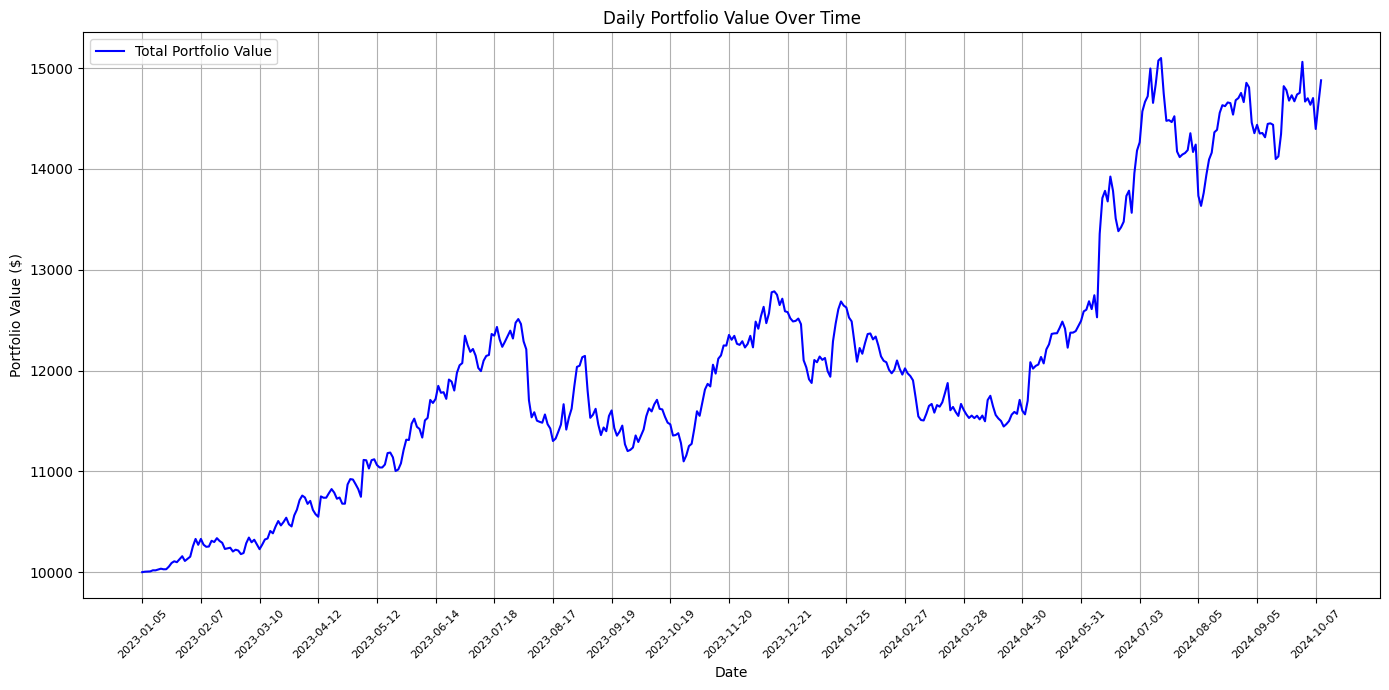


Initial Cash: $10000.00
Final Portfolio Value: $14879.08
Total Profit or Loss: $4879.08


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the prediction dataset and original data
predictions = pd.read_csv("u14_predictions7.csv")
original_data = pd.read_csv("data.csv")

# Ensure both datasets have the same index for consistent calculations
predictions['timestamp'] = pd.to_datetime(predictions['Date'])
original_data['timestamp'] = pd.to_datetime(original_data['Date'])
merged = pd.merge(predictions[['timestamp', 'Predicted_BuyOrSell']], original_data[['timestamp', 'Close']], on='timestamp')
merged.sort_values(by='timestamp', inplace=True)

# Initial conditions
initial_cash = 10000.0
cash = initial_cash
stocks = 0

# DataFrame to track daily account changes
account_changes = []

# Simulate trading
for index, row in merged.iterrows():
    action = row['Predicted_BuyOrSell']
    price = row['Close']

    if action == 'buy' and cash >= price:
        # Buy 1 stock if we have enough cash
        cash -= price
        stocks += 1
    elif action == 'sell' and stocks > 0:
        # Sell 1 stock if we have any holdings
        cash += price
        stocks -= 1

    # Record daily account value
    total_value = cash + (stocks * price)
    account_changes.append({'Date': row['timestamp'], 'Cash': cash, 'Stocks': stocks, 'Total Value': total_value})

    # Corrected print statement for daily account changes
    print(f"Date: {row['timestamp']}, Cash: {cash:.2f}, Stocks: {stocks}, Total Value: {total_value:.2f}")

# Create DataFrame from account changes
account_df = pd.DataFrame(account_changes)

# Format the Date for better readability
account_df['Date'] = account_df['Date'].dt.strftime('%Y-%m-%d')

# Print daily account changes with expanded date
print("Daily Account Changes:")
print(account_df)

# Plot daily account value changes with more x-axis ticks for better visibility
plt.figure(figsize=(14, 7))
plt.plot(account_df['Date'], account_df['Total Value'], label='Total Portfolio Value', color='blue')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Daily Portfolio Value Over Time')
plt.xticks(rotation=45, fontsize=8)  # Rotate the x-axis labels for better readability and expand tick size
plt.xticks(ticks=range(0, len(account_df), max(1, len(account_df)//20)), rotation=45)  # Show more ticks, but not overcrowded
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final earnings calculation
final_value = account_df.iloc[-1]['Total Value']
profit_or_loss = final_value - initial_cash

# Print final earnings
print(f"\nInitial Cash: ${initial_cash:.2f}")
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Profit or Loss: ${profit_or_loss:.2f}")


Date: 2023-01-05 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 100000.00
Date: 2023-01-06 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 103675.40
Date: 2023-01-09 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 104098.87
Date: 2023-01-10 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 104562.29
Date: 2023-01-11 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 106767.54
Date: 2023-01-12 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 106703.62
Date: 2023-01-13 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 107782.26
Date: 2023-01-17 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 108725.08
Date: 2023-01-18 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 108141.82
Date: 2023-01-19 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 108189.76
Date: 2023-01-20 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 110267.15
Date: 2023-01-23 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 112855.91
Date: 2023-01-24 00:00:00, Cash: 109.02, Stocks: 799

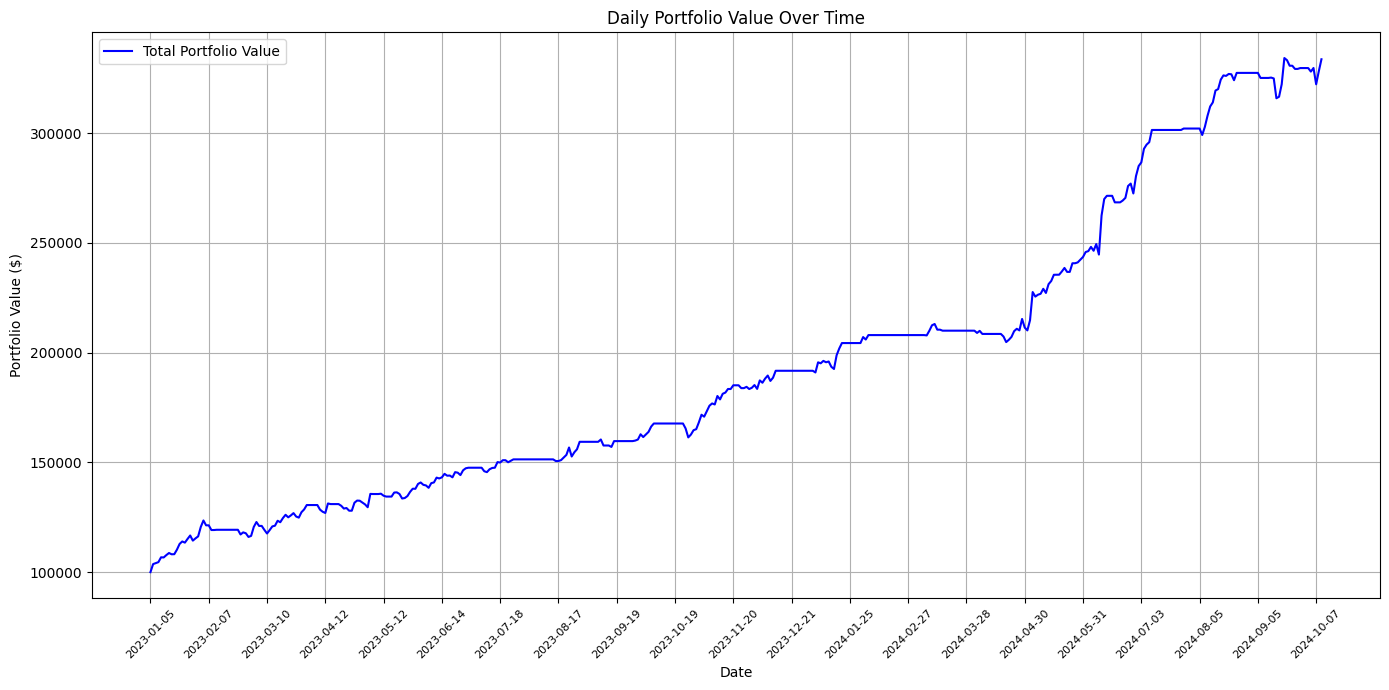


Initial Cash: $100000.00
Final Portfolio Value: $333706.02
Total Profit or Loss: $233706.02


In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the prediction dataset and original data
predictions = pd.read_csv("u14_predictions7.csv")
original_data = pd.read_csv("data.csv")

# Ensure both datasets have the same index for consistent calculations
predictions['timestamp'] = pd.to_datetime(predictions['Date'])
original_data['timestamp'] = pd.to_datetime(original_data['Date'])
merged = pd.merge(predictions[['timestamp', 'Predicted_BuyOrSell']], original_data[['timestamp', 'Close']], on='timestamp')
merged.sort_values(by='timestamp', inplace=True)

# Initial conditions
initial_cash = 100000.0
cash = initial_cash
stocks = 0

# DataFrame to track daily account changes
account_changes = []

# Simulate trading
for index, row in merged.iterrows():
    action = row['Predicted_BuyOrSell']
    price = row['Close']

    if action == 'buy' and cash >= price:
        # Buy as many stocks as we can afford with the available cash
        num_stocks_to_buy = cash // price
        cash -= num_stocks_to_buy * price
        stocks += num_stocks_to_buy
    elif action == 'sell' and stocks > 0:
        # Sell all stocks currently held
        cash += stocks * price
        stocks = 0

    # Record daily account value
    total_value = cash + (stocks * price)
    account_changes.append({'Date': row['timestamp'], 'Cash': cash, 'Stocks': stocks, 'Total Value': total_value})

    # Corrected print statement for daily account changes
    print(f"Date: {row['timestamp']}, Cash: {cash:.2f}, Stocks: {stocks}, Total Value: {total_value:.2f}")

# Create DataFrame from account changes
account_df = pd.DataFrame(account_changes)

# Format the Date for better readability
account_df['Date'] = account_df['Date'].dt.strftime('%Y-%m-%d')

# Print daily account changes with expanded date
print("\nDaily Account Changes:")
print(account_df)

# Plot daily account value changes with more x-axis ticks for better visibility
plt.figure(figsize=(14, 7))
plt.plot(account_df['Date'], account_df['Total Value'], label='Total Portfolio Value', color='blue')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Daily Portfolio Value Over Time')
plt.xticks(rotation=45, fontsize=8)  # Rotate the x-axis labels for better readability and expand tick size
plt.xticks(ticks=range(0, len(account_df), max(1, len(account_df) // 20)), rotation=45)  # Show more ticks, but not overcrowded
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final earnings calculation
final_value = account_df.iloc[-1]['Total Value']
profit_or_loss = final_value - initial_cash

# Print final earnings
print(f"\nInitial Cash: ${initial_cash:.2f}")
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Profit or Loss: ${profit_or_loss:.2f}")


# moving average is 5

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Loss: 0.10739173740148544, Validation Loss: 0.06013333424925804
Epoch 2, Loss: 0.04754867032170296, Validation Loss: 0.0569409504532814
Epoch 3, Loss: 0.07413499057292938, Validation Loss: 0.05325203016400337
Epoch 4, Loss: 0.02676038071513176, Validation Loss: 0.026413923129439354
Epoch 5, Loss: 0.013698197901248932, Validation Loss: 0.009124248288571835
Epoch 6, Loss: 0.0037591243162751198, Validation Loss: 0.004359651822596788
Epoch 7, Loss: 0.0033924684394150972, Validation Loss: 0.0013541615335270762
Epoch 8, Loss: 0.0008051452459767461, Validation Loss: 0.0010096508776769042
Epoch 9, Loss: 0.000430340354796499, Validation Loss: 0.0004264989693183452
Epoch 10, Loss: 0.000800267152953893, Validation Loss: 0.00022215356875676662
Epoch 11, Loss: 0.00028162726084701717, Validation Loss: 0.00014784475206397474
Epoch 12, Loss: 0.00021907298651058227, Validation Loss: 7.068915147101507e-05
Epoch 13, Loss: 0.0003392818907741457, Validation Loss: 3.627041223808192e-05
Epoch 14, Lo

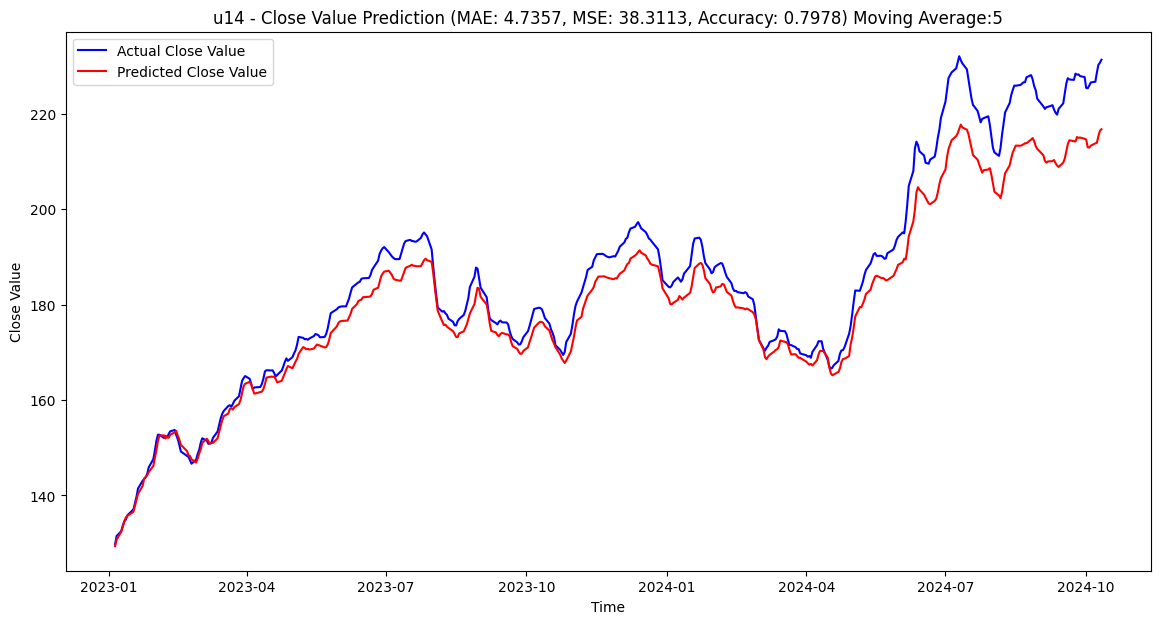

Predictions saved to u14_predictions5.csv
d142 - MAE: 0.7161, MSE: 3.0869
d142 - Buy/Sell Accuracy: 0.8112


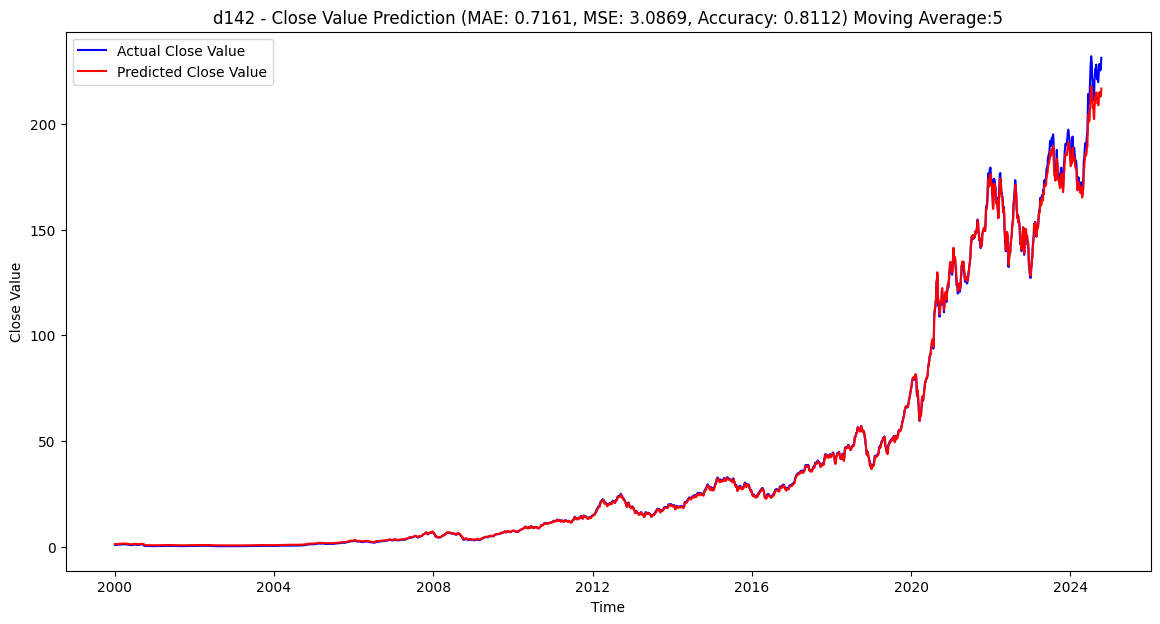

Predictions saved to d142_predictions5.csv


In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Load the training dataset
data = pd.read_csv('train.csv')

# Use only 'Close' column as the target and features for LSTM model
data['timestamp'] = pd.to_datetime(data['Date'])
data.set_index('timestamp', inplace=True)
data.sort_index(inplace=True)
close_prices = data[['Close']]

# Apply moving average to denoise the data
window_ma = 5
close_prices_denoised = close_prices.rolling(window=window_ma).mean().dropna()

# Normalizing the training data
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(close_prices_denoised)
data_scaled_df = pd.DataFrame(scaled_values, columns=close_prices_denoised.columns, index=close_prices_denoised.index)

# Sequence function
def create_sequence(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i - window_size:i].values)
        y.append(data.iloc[i]['Close'])
    return np.array(X), np.array(y)

# Create sequences for training
window_size = 1
X, y = create_sequence(data_scaled_df, window_size)

# Split data (randomly)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Make y a column vector
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Load data in batches
batch_size = 512
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=1, num_layers=4):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

input_dim = X_train.shape[2]
model = LSTMModel(input_dim=input_dim, output_dim=1).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler for adaptive learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training with early stopping
num_epochs = 100
early_stop_patience = 10
best_loss = float('inf')
patience = 0
best_model = None

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test.to(device))
        val_loss = criterion(val_outputs, y_test.to(device))

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

    # Step the scheduler with the validation loss
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience = 0
        best_model = model.state_dict()
    else:
        patience += 1
        print("current patience:", patience)

        if patience >= early_stop_patience:
            print("Early stopping")
            break

# Load the best model
model.load_state_dict(best_model)

# Function to predict, evaluate, plot, and save to CSV
def predict_evaluate_plot_save(undata_filename, model, scaler, window_size, title_prefix):
    # Load the prediction dataset
    undata = pd.read_csv(undata_filename)
    undata['timestamp'] = pd.to_datetime(undata['Date'])
    undata.set_index('timestamp', inplace=True)
    undata.sort_index(inplace=True)
    close_prices_undata = undata[['Close']]

    # Apply moving average to denoise the prediction dataset
    close_prices_undata_denoised = close_prices_undata.rolling(window=window_ma).mean().dropna()

    # Normalizing the prediction dataset
    scaled_values_undata = scaler.transform(close_prices_undata_denoised)
    undata_scaled_df = pd.DataFrame(scaled_values_undata, columns=close_prices_undata_denoised.columns, index=close_prices_undata_denoised.index)

    # Create sequences for prediction
    X_undata, y_undata = create_sequence(undata_scaled_df, window_size)
    X_undata = torch.tensor(X_undata, dtype=torch.float32).to(device)

    # Predictions for the new dataset
    model.eval()
    with torch.no_grad():
        predictions_undata = model(X_undata).cpu().numpy()

    # Inverse transform the predictions and actual values
    y_undata_combined = np.concatenate((y_undata.reshape(-1, 1), np.zeros((y_undata.shape[0], undata_scaled_df.shape[1] - 1))), axis=1)
    y_undata_rescaled = scaler.inverse_transform(y_undata_combined)[:, 0]

    predictions_undata_combined = np.concatenate((predictions_undata, np.zeros((predictions_undata.shape[0], undata_scaled_df.shape[1] - 1))), axis=1)
    predictions_undata_rescaled = scaler.inverse_transform(predictions_undata_combined)[:, 0]

    # Ensure lengths match for plotting and saving
    min_length = min(len(y_undata_rescaled), len(predictions_undata_rescaled))
    y_undata_rescaled = y_undata_rescaled[:min_length]
    predictions_undata_rescaled = predictions_undata_rescaled[:min_length]

    # Calculate MAE and MSE
    mae_undata = mean_absolute_error(y_undata_rescaled, predictions_undata_rescaled)
    mse_undata = mean_squared_error(y_undata_rescaled, predictions_undata_rescaled)
    print(f"{title_prefix} - MAE: {mae_undata:.4f}, MSE: {mse_undata:.4f}")

    # Create 'buyorsell' labels based on predicted price movements
    actual_buyorsell = []
    predicted_buyorsell = []
    for i in range(len(predictions_undata_rescaled) - 1):
        if y_undata_rescaled[i+1] > y_undata_rescaled[i]:
            actual_buyorsell.append('buy')
        else:
            actual_buyorsell.append('sell')

        if predictions_undata_rescaled[i+1] > predictions_undata_rescaled[i]:
            predicted_buyorsell.append('buy')
        else:
            predicted_buyorsell.append('sell')

    # Assign the last label for buy/sell to avoid exceeding range
    actual_buyorsell.append('buy' if y_undata_rescaled[-1] > y_undata_rescaled[-2] else 'sell')
    predicted_buyorsell.append('buy' if predictions_undata_rescaled[-1] > predictions_undata_rescaled[-2] else 'sell')

    # Calculate accuracy of 'buyorsell' predictions
    actual_buyorsell = np.array(actual_buyorsell)
    predicted_buyorsell = np.array(predicted_buyorsell)
    accuracy = accuracy_score(actual_buyorsell, predicted_buyorsell)
    print(f"{title_prefix} - Buy/Sell Accuracy: {accuracy:.4f}")

    # Plot
    plt.figure(figsize=(14, 7))
    plt.plot(undata.index[window_size:window_size + min_length], y_undata_rescaled, color='blue', label='Actual Close Value')
    plt.plot(undata.index[window_size:window_size + min_length], predictions_undata_rescaled, color='red', label='Predicted Close Value')
    plt.title(f'{title_prefix} - Close Value Prediction (MAE: {mae_undata:.4f}, MSE: {mse_undata:.4f}, Accuracy: {accuracy:.4f}) Moving Average:{window_ma}')
    plt.xlabel('Time')
    plt.ylabel('Close Value')
    plt.legend()
    plt.show()

    # Save the predicted results to CSV
    undata_result = undata.iloc[window_size:window_size + min_length].copy()  # Align lengths properly
    undata_result['Predicted_Close'] = predictions_undata_rescaled  # Assign predictions
    undata_result['Predicted_BuyOrSell'] = predicted_buyorsell  # Assign predicted buy/sell labels
    undata_result.to_csv(f"{title_prefix}_predictions{window_ma}.csv", index=True)
    print(f"Predictions saved to {title_prefix}_predictions{window_ma}.csv")

# Apply model to 'u14.csv'
predict_evaluate_plot_save('undata.csv', model, scaler, window_size, title_prefix='u14')

# Apply model to 'd142.csv'
predict_evaluate_plot_save('data.csv', model, scaler, window_size, title_prefix='d142')


Date: 2023-01-05 00:00:00, Cash: 9874.98, Stocks: 1, Total Value: 10000.00
Date: 2023-01-06 00:00:00, Cash: 9745.36, Stocks: 2, Total Value: 10004.60
Date: 2023-01-09 00:00:00, Cash: 9615.21, Stocks: 3, Total Value: 10005.66
Date: 2023-01-10 00:00:00, Cash: 9484.48, Stocks: 4, Total Value: 10007.40
Date: 2023-01-11 00:00:00, Cash: 9350.99, Stocks: 5, Total Value: 10018.44
Date: 2023-01-12 00:00:00, Cash: 9217.58, Stocks: 6, Total Value: 10018.04
Date: 2023-01-13 00:00:00, Cash: 9082.82, Stocks: 7, Total Value: 10026.14
Date: 2023-01-17 00:00:00, Cash: 8946.88, Stocks: 8, Total Value: 10034.40
Date: 2023-01-18 00:00:00, Cash: 8811.67, Stocks: 9, Total Value: 10028.56
Date: 2023-01-19 00:00:00, Cash: 8676.40, Stocks: 10, Total Value: 10029.10
Date: 2023-01-20 00:00:00, Cash: 8538.53, Stocks: 11, Total Value: 10055.10
Date: 2023-01-23 00:00:00, Cash: 8397.42, Stocks: 12, Total Value: 10090.74
Date: 2023-01-24 00:00:00, Cash: 8254.89, Stocks: 13, Total Value: 10107.78
Date: 2023-01-25 00:0

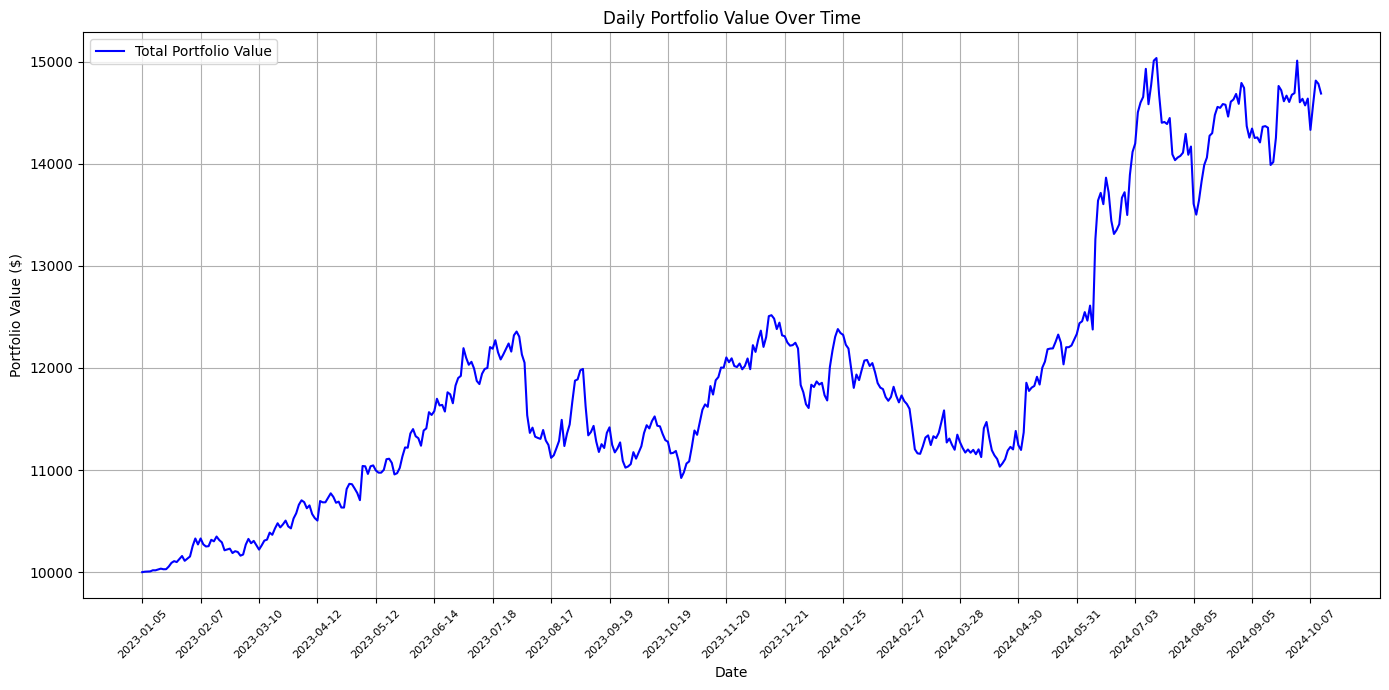


Initial Cash: $10000.00
Final Portfolio Value: $14686.48
Total Profit or Loss: $4686.48


In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the prediction dataset and original data
predictions = pd.read_csv("u14_predictions5.csv")
original_data = pd.read_csv("data.csv")

# Ensure both datasets have the same index for consistent calculations
predictions['timestamp'] = pd.to_datetime(predictions['Date'])
original_data['timestamp'] = pd.to_datetime(original_data['Date'])
merged = pd.merge(predictions[['timestamp', 'Predicted_BuyOrSell']], original_data[['timestamp', 'Close']], on='timestamp')
merged.sort_values(by='timestamp', inplace=True)

# Initial conditions
initial_cash = 10000.0
cash = initial_cash
stocks = 0

# DataFrame to track daily account changes
account_changes = []

# Simulate trading
for index, row in merged.iterrows():
    action = row['Predicted_BuyOrSell']
    price = row['Close']

    if action == 'buy' and cash >= price:
        # Buy 1 stock if we have enough cash
        cash -= price
        stocks += 1
    elif action == 'sell' and stocks > 0:
        # Sell 1 stock if we have any holdings
        cash += price
        stocks -= 1

    # Record daily account value
    total_value = cash + (stocks * price)
    account_changes.append({'Date': row['timestamp'], 'Cash': cash, 'Stocks': stocks, 'Total Value': total_value})

    # Corrected print statement for daily account changes
    print(f"Date: {row['timestamp']}, Cash: {cash:.2f}, Stocks: {stocks}, Total Value: {total_value:.2f}")

# Create DataFrame from account changes
account_df = pd.DataFrame(account_changes)

# Format the Date for better readability
account_df['Date'] = account_df['Date'].dt.strftime('%Y-%m-%d')

# Print daily account changes with expanded date
print("Daily Account Changes:")
print(account_df)

# Plot daily account value changes with more x-axis ticks for better visibility
plt.figure(figsize=(14, 7))
plt.plot(account_df['Date'], account_df['Total Value'], label='Total Portfolio Value', color='blue')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Daily Portfolio Value Over Time')
plt.xticks(rotation=45, fontsize=8)  # Rotate the x-axis labels for better readability and expand tick size
plt.xticks(ticks=range(0, len(account_df), max(1, len(account_df)//20)), rotation=45)  # Show more ticks, but not overcrowded
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final earnings calculation
final_value = account_df.iloc[-1]['Total Value']
profit_or_loss = final_value - initial_cash

# Print final earnings
print(f"\nInitial Cash: ${initial_cash:.2f}")
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Profit or Loss: ${profit_or_loss:.2f}")


Date: 2023-01-05 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 100000.00
Date: 2023-01-06 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 103675.40
Date: 2023-01-09 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 104098.87
Date: 2023-01-10 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 104562.29
Date: 2023-01-11 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 106767.54
Date: 2023-01-12 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 106703.62
Date: 2023-01-13 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 107782.26
Date: 2023-01-17 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 108725.08
Date: 2023-01-18 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 108141.82
Date: 2023-01-19 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 108189.76
Date: 2023-01-20 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 110267.15
Date: 2023-01-23 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 112855.91
Date: 2023-01-24 00:00:00, Cash: 109.02, Stocks: 799

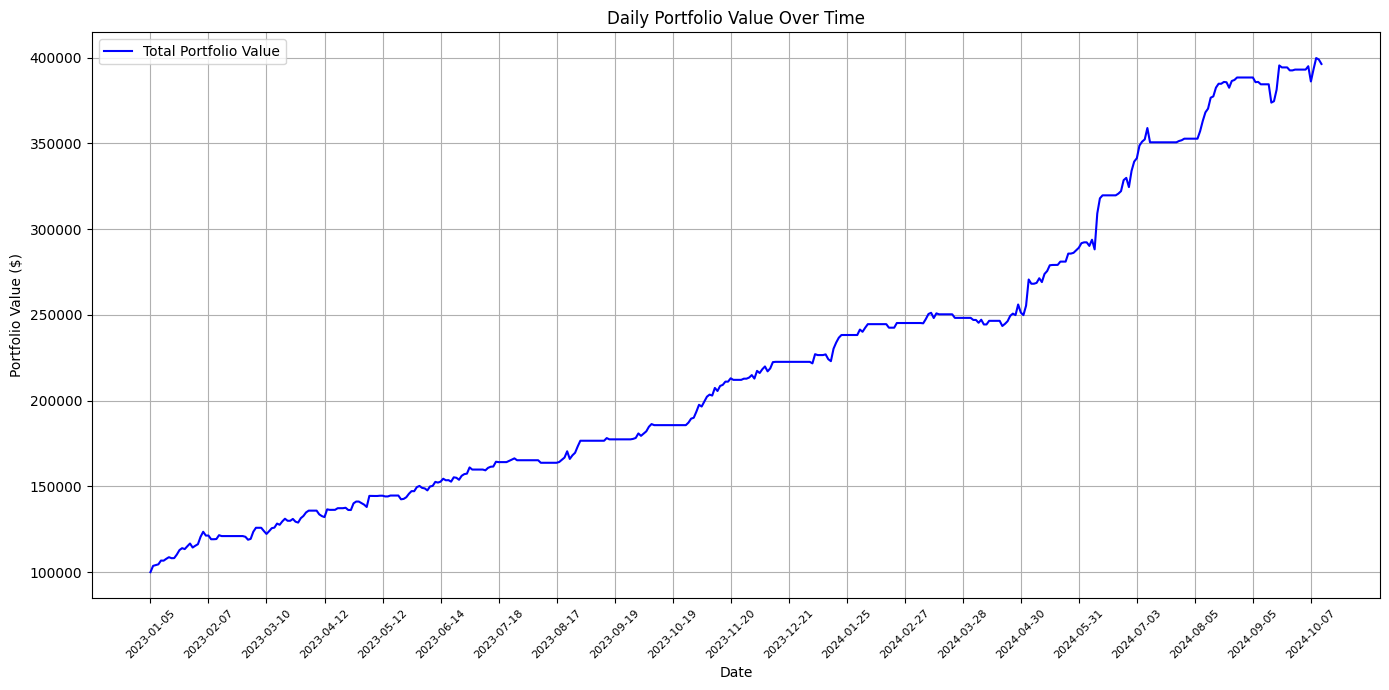


Initial Cash: $100000.00
Final Portfolio Value: $396320.96
Total Profit or Loss: $296320.96


In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the prediction dataset and original data
predictions = pd.read_csv("u14_predictions5.csv")
original_data = pd.read_csv("data.csv")

# Ensure both datasets have the same index for consistent calculations
predictions['timestamp'] = pd.to_datetime(predictions['Date'])
original_data['timestamp'] = pd.to_datetime(original_data['Date'])
merged = pd.merge(predictions[['timestamp', 'Predicted_BuyOrSell']], original_data[['timestamp', 'Close']], on='timestamp')
merged.sort_values(by='timestamp', inplace=True)

# Initial conditions
initial_cash = 100000.0
cash = initial_cash
stocks = 0

# DataFrame to track daily account changes
account_changes = []

# Simulate trading
for index, row in merged.iterrows():
    action = row['Predicted_BuyOrSell']
    price = row['Close']

    if action == 'buy' and cash >= price:
        # Buy as many stocks as we can afford with the available cash
        num_stocks_to_buy = cash // price
        cash -= num_stocks_to_buy * price
        stocks += num_stocks_to_buy
    elif action == 'sell' and stocks > 0:
        # Sell all stocks currently held
        cash += stocks * price
        stocks = 0

    # Record daily account value
    total_value = cash + (stocks * price)
    account_changes.append({'Date': row['timestamp'], 'Cash': cash, 'Stocks': stocks, 'Total Value': total_value})

    # Corrected print statement for daily account changes
    print(f"Date: {row['timestamp']}, Cash: {cash:.2f}, Stocks: {stocks}, Total Value: {total_value:.2f}")

# Create DataFrame from account changes
account_df = pd.DataFrame(account_changes)

# Format the Date for better readability
account_df['Date'] = account_df['Date'].dt.strftime('%Y-%m-%d')

# Print daily account changes with expanded date
print("\nDaily Account Changes:")
print(account_df)

# Plot daily account value changes with more x-axis ticks for better visibility
plt.figure(figsize=(14, 7))
plt.plot(account_df['Date'], account_df['Total Value'], label='Total Portfolio Value', color='blue')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Daily Portfolio Value Over Time')
plt.xticks(rotation=45, fontsize=8)  # Rotate the x-axis labels for better readability and expand tick size
plt.xticks(ticks=range(0, len(account_df), max(1, len(account_df) // 20)), rotation=45)  # Show more ticks, but not overcrowded
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final earnings calculation
final_value = account_df.iloc[-1]['Total Value']
profit_or_loss = final_value - initial_cash

# Print final earnings
print(f"\nInitial Cash: ${initial_cash:.2f}")
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Profit or Loss: ${profit_or_loss:.2f}")


# try moving average for 10

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Loss: 0.020665403455495834, Validation Loss: 0.061299704015254974
Epoch 2, Loss: 0.02405656687915325, Validation Loss: 0.059874169528484344
Epoch 3, Loss: 0.07410196214914322, Validation Loss: 0.052613575011491776
Epoch 4, Loss: 0.023564035072922707, Validation Loss: 0.014559334143996239
Epoch 5, Loss: 0.009563829749822617, Validation Loss: 0.0031917900778353214
Epoch 6, Loss: 0.00369183998554945, Validation Loss: 0.004507226869463921
current patience: 1
Epoch 7, Loss: 0.0011472426122054458, Validation Loss: 0.0017254980048164725
Epoch 8, Loss: 0.001082781353034079, Validation Loss: 0.0008946337620727718
Epoch 9, Loss: 0.00020902013056911528, Validation Loss: 0.00045199357555247843
Epoch 10, Loss: 0.0010244639124721289, Validation Loss: 0.0003117330197710544
Epoch 11, Loss: 0.00029335645376704633, Validation Loss: 0.00022349819482769817
Epoch 12, Loss: 0.00029582754359580576, Validation Loss: 0.00011955374793615192
Epoch 13, Loss: 0.00045790441799908876, Validation Loss: 7.880

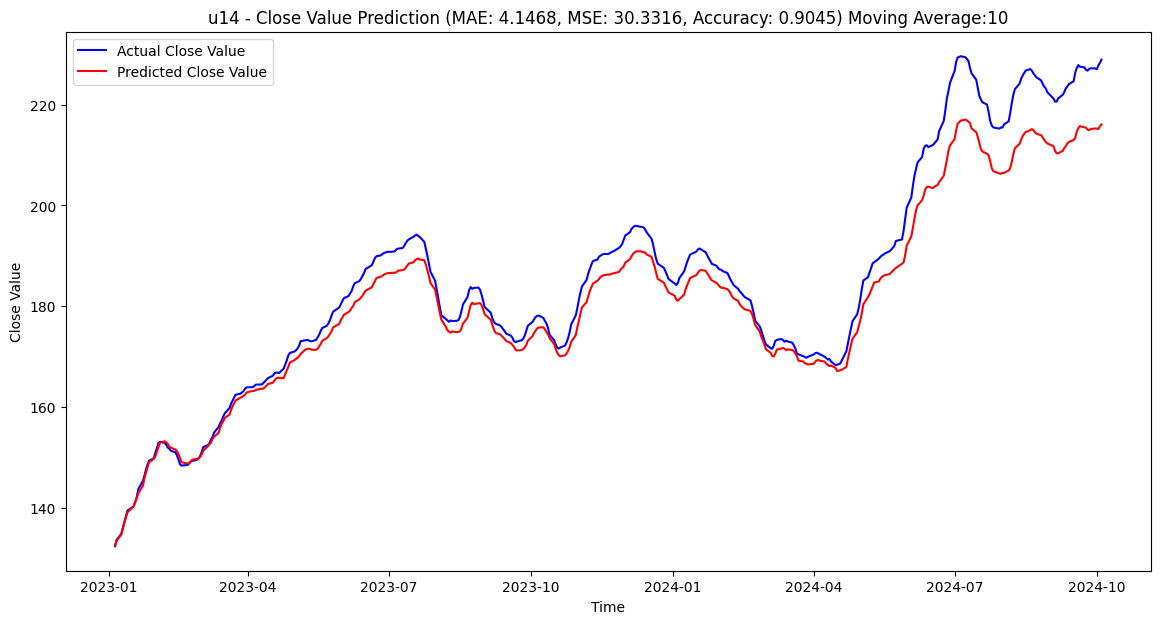

Predictions saved to u14_predictions10.csv
d142 - MAE: 0.5865, MSE: 2.3677
d142 - Buy/Sell Accuracy: 0.8711


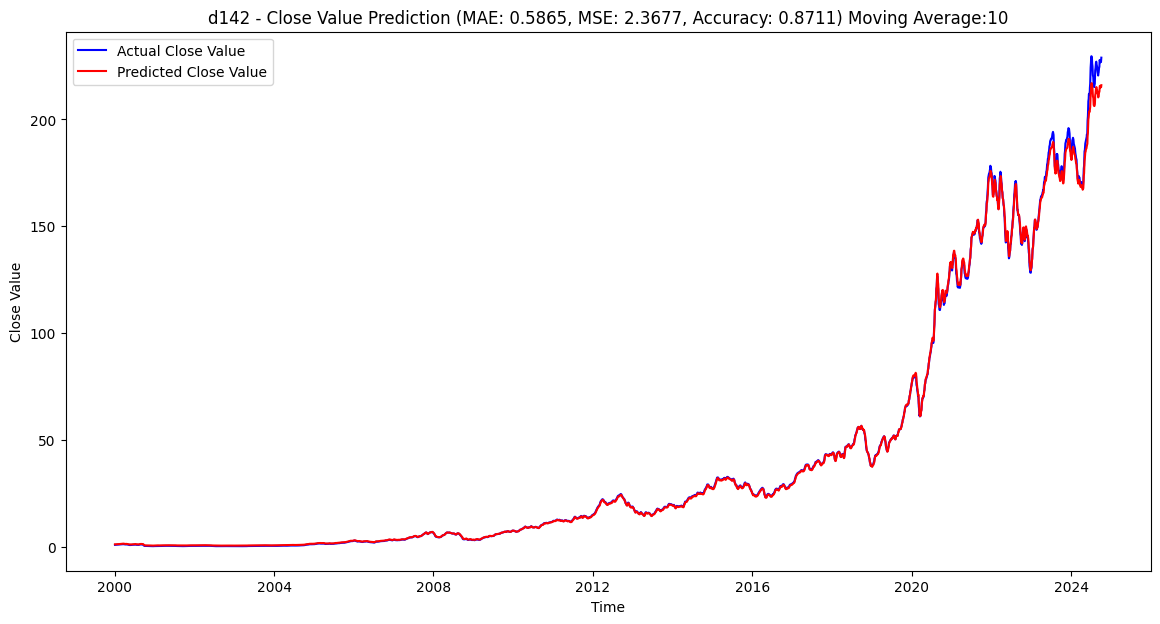

Predictions saved to d142_predictions10.csv


In [26]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Load the training dataset
data = pd.read_csv('train.csv')

# Use only 'Close' column as the target and features for LSTM model
data['timestamp'] = pd.to_datetime(data['Date'])
data.set_index('timestamp', inplace=True)
data.sort_index(inplace=True)
close_prices = data[['Close']]

# Apply moving average to denoise the data
window_ma = 10
close_prices_denoised = close_prices.rolling(window=window_ma).mean().dropna()

# Normalizing the training data
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(close_prices_denoised)
data_scaled_df = pd.DataFrame(scaled_values, columns=close_prices_denoised.columns, index=close_prices_denoised.index)

# Sequence function
def create_sequence(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i - window_size:i].values)
        y.append(data.iloc[i]['Close'])
    return np.array(X), np.array(y)

# Create sequences for training
window_size = 1
X, y = create_sequence(data_scaled_df, window_size)

# Split data (randomly)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Make y a column vector
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Load data in batches
batch_size = 512
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=1, num_layers=4):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

input_dim = X_train.shape[2]
model = LSTMModel(input_dim=input_dim, output_dim=1).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler for adaptive learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training with early stopping
num_epochs = 100
early_stop_patience = 10
best_loss = float('inf')
patience = 0
best_model = None

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test.to(device))
        val_loss = criterion(val_outputs, y_test.to(device))

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

    # Step the scheduler with the validation loss
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience = 0
        best_model = model.state_dict()
    else:
        patience += 1
        print("current patience:", patience)

        if patience >= early_stop_patience:
            print("Early stopping")
            break

# Load the best model
model.load_state_dict(best_model)

# Function to predict, evaluate, plot, and save to CSV
def predict_evaluate_plot_save(undata_filename, model, scaler, window_size, title_prefix):
    # Load the prediction dataset
    undata = pd.read_csv(undata_filename)
    undata['timestamp'] = pd.to_datetime(undata['Date'])
    undata.set_index('timestamp', inplace=True)
    undata.sort_index(inplace=True)
    close_prices_undata = undata[['Close']]

    # Apply moving average to denoise the prediction dataset
    close_prices_undata_denoised = close_prices_undata.rolling(window=window_ma).mean().dropna()

    # Normalizing the prediction dataset
    scaled_values_undata = scaler.transform(close_prices_undata_denoised)
    undata_scaled_df = pd.DataFrame(scaled_values_undata, columns=close_prices_undata_denoised.columns, index=close_prices_undata_denoised.index)

    # Create sequences for prediction
    X_undata, y_undata = create_sequence(undata_scaled_df, window_size)
    X_undata = torch.tensor(X_undata, dtype=torch.float32).to(device)

    # Predictions for the new dataset
    model.eval()
    with torch.no_grad():
        predictions_undata = model(X_undata).cpu().numpy()

    # Inverse transform the predictions and actual values
    y_undata_combined = np.concatenate((y_undata.reshape(-1, 1), np.zeros((y_undata.shape[0], undata_scaled_df.shape[1] - 1))), axis=1)
    y_undata_rescaled = scaler.inverse_transform(y_undata_combined)[:, 0]

    predictions_undata_combined = np.concatenate((predictions_undata, np.zeros((predictions_undata.shape[0], undata_scaled_df.shape[1] - 1))), axis=1)
    predictions_undata_rescaled = scaler.inverse_transform(predictions_undata_combined)[:, 0]

    # Ensure lengths match for plotting and saving
    min_length = min(len(y_undata_rescaled), len(predictions_undata_rescaled))
    y_undata_rescaled = y_undata_rescaled[:min_length]
    predictions_undata_rescaled = predictions_undata_rescaled[:min_length]

    # Calculate MAE and MSE
    mae_undata = mean_absolute_error(y_undata_rescaled, predictions_undata_rescaled)
    mse_undata = mean_squared_error(y_undata_rescaled, predictions_undata_rescaled)
    print(f"{title_prefix} - MAE: {mae_undata:.4f}, MSE: {mse_undata:.4f}")

    # Create 'buyorsell' labels based on predicted price movements
    actual_buyorsell = []
    predicted_buyorsell = []
    for i in range(len(predictions_undata_rescaled) - 1):
        if y_undata_rescaled[i+1] > y_undata_rescaled[i]:
            actual_buyorsell.append('buy')
        else:
            actual_buyorsell.append('sell')

        if predictions_undata_rescaled[i+1] > predictions_undata_rescaled[i]:
            predicted_buyorsell.append('buy')
        else:
            predicted_buyorsell.append('sell')

    # Assign the last label for buy/sell to avoid exceeding range
    actual_buyorsell.append('buy' if y_undata_rescaled[-1] > y_undata_rescaled[-2] else 'sell')
    predicted_buyorsell.append('buy' if predictions_undata_rescaled[-1] > predictions_undata_rescaled[-2] else 'sell')

    # Calculate accuracy of 'buyorsell' predictions
    actual_buyorsell = np.array(actual_buyorsell)
    predicted_buyorsell = np.array(predicted_buyorsell)
    accuracy = accuracy_score(actual_buyorsell, predicted_buyorsell)
    print(f"{title_prefix} - Buy/Sell Accuracy: {accuracy:.4f}")

    # Plot
    plt.figure(figsize=(14, 7))
    plt.plot(undata.index[window_size:window_size + min_length], y_undata_rescaled, color='blue', label='Actual Close Value')
    plt.plot(undata.index[window_size:window_size + min_length], predictions_undata_rescaled, color='red', label='Predicted Close Value')
    plt.title(f'{title_prefix} - Close Value Prediction (MAE: {mae_undata:.4f}, MSE: {mse_undata:.4f}, Accuracy: {accuracy:.4f}) Moving Average:{window_ma}')
    plt.xlabel('Time')
    plt.ylabel('Close Value')
    plt.legend()
    plt.show()

    # Save the predicted results to CSV
    undata_result = undata.iloc[window_size:window_size + min_length].copy()  # Align lengths properly
    undata_result['Predicted_Close'] = predictions_undata_rescaled  # Assign predictions
    undata_result['Predicted_BuyOrSell'] = predicted_buyorsell  # Assign predicted buy/sell labels
    undata_result.to_csv(f"{title_prefix}_predictions{window_ma}.csv", index=True)
    print(f"Predictions saved to {title_prefix}_predictions{window_ma}.csv")

# Apply model to 'u14.csv'
predict_evaluate_plot_save('undata.csv', model, scaler, window_size, title_prefix='u14')

# Apply model to 'd142.csv'
predict_evaluate_plot_save('data.csv', model, scaler, window_size, title_prefix='d142')


Date: 2023-01-05 00:00:00, Cash: 9874.98, Stocks: 1, Total Value: 10000.00
Date: 2023-01-06 00:00:00, Cash: 9745.36, Stocks: 2, Total Value: 10004.60
Date: 2023-01-09 00:00:00, Cash: 9615.21, Stocks: 3, Total Value: 10005.66
Date: 2023-01-10 00:00:00, Cash: 9484.48, Stocks: 4, Total Value: 10007.40
Date: 2023-01-11 00:00:00, Cash: 9350.99, Stocks: 5, Total Value: 10018.44
Date: 2023-01-12 00:00:00, Cash: 9217.58, Stocks: 6, Total Value: 10018.04
Date: 2023-01-13 00:00:00, Cash: 9082.82, Stocks: 7, Total Value: 10026.14
Date: 2023-01-17 00:00:00, Cash: 8946.88, Stocks: 8, Total Value: 10034.40
Date: 2023-01-18 00:00:00, Cash: 8811.67, Stocks: 9, Total Value: 10028.56
Date: 2023-01-19 00:00:00, Cash: 8676.40, Stocks: 10, Total Value: 10029.10
Date: 2023-01-20 00:00:00, Cash: 8538.53, Stocks: 11, Total Value: 10055.10
Date: 2023-01-23 00:00:00, Cash: 8397.42, Stocks: 12, Total Value: 10090.74
Date: 2023-01-24 00:00:00, Cash: 8254.89, Stocks: 13, Total Value: 10107.78
Date: 2023-01-25 00:0

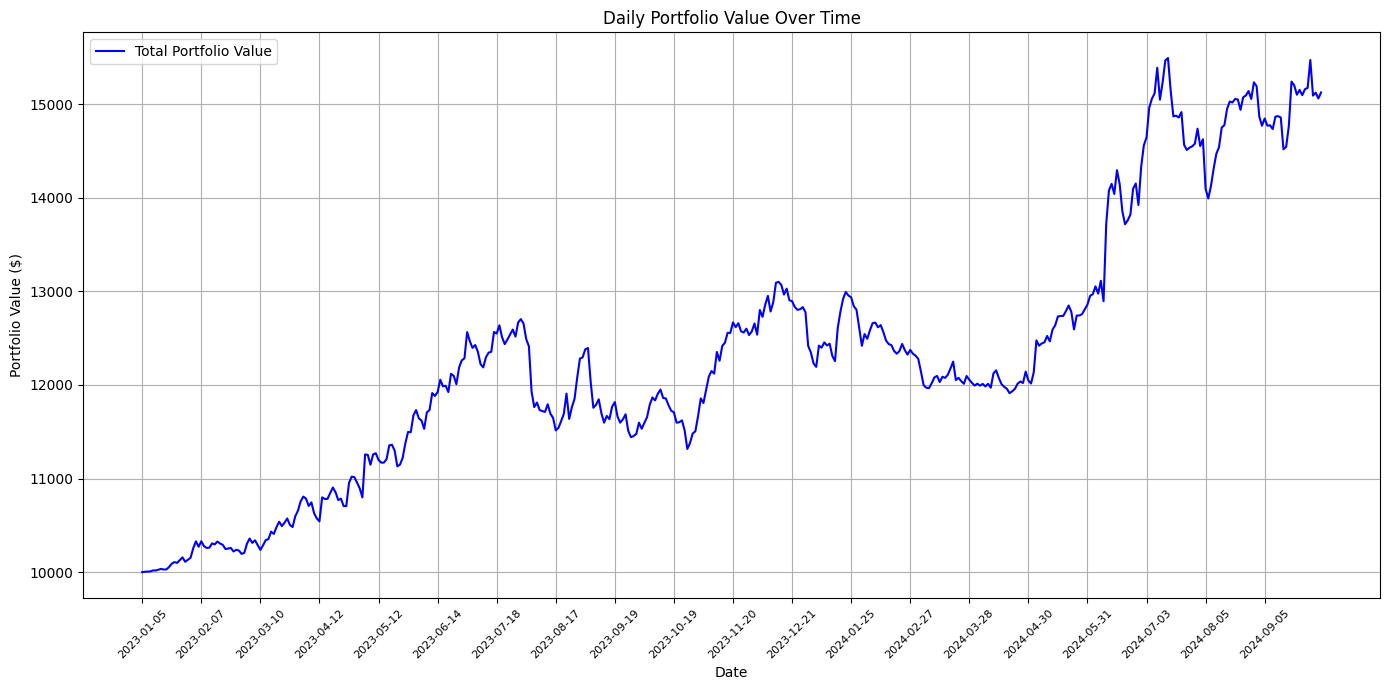


Initial Cash: $10000.00
Final Portfolio Value: $15125.55
Total Profit or Loss: $5125.55


In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the prediction dataset and original data
predictions = pd.read_csv("u14_predictions10.csv")
original_data = pd.read_csv("data.csv")

# Ensure both datasets have the same index for consistent calculations
predictions['timestamp'] = pd.to_datetime(predictions['Date'])
original_data['timestamp'] = pd.to_datetime(original_data['Date'])
merged = pd.merge(predictions[['timestamp', 'Predicted_BuyOrSell']], original_data[['timestamp', 'Close']], on='timestamp')
merged.sort_values(by='timestamp', inplace=True)

# Initial conditions
initial_cash = 10000.0
cash = initial_cash
stocks = 0

# DataFrame to track daily account changes
account_changes = []

# Simulate trading
for index, row in merged.iterrows():
    action = row['Predicted_BuyOrSell']
    price = row['Close']

    if action == 'buy' and cash >= price:
        # Buy 1 stock if we have enough cash
        cash -= price
        stocks += 1
    elif action == 'sell' and stocks > 0:
        # Sell 1 stock if we have any holdings
        cash += price
        stocks -= 1

    # Record daily account value
    total_value = cash + (stocks * price)
    account_changes.append({'Date': row['timestamp'], 'Cash': cash, 'Stocks': stocks, 'Total Value': total_value})

    # Corrected print statement for daily account changes
    print(f"Date: {row['timestamp']}, Cash: {cash:.2f}, Stocks: {stocks}, Total Value: {total_value:.2f}")

# Create DataFrame from account changes
account_df = pd.DataFrame(account_changes)

# Format the Date for better readability
account_df['Date'] = account_df['Date'].dt.strftime('%Y-%m-%d')

# Print daily account changes with expanded date
print("Daily Account Changes:")
print(account_df)

# Plot daily account value changes with more x-axis ticks for better visibility
plt.figure(figsize=(14, 7))
plt.plot(account_df['Date'], account_df['Total Value'], label='Total Portfolio Value', color='blue')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Daily Portfolio Value Over Time')
plt.xticks(rotation=45, fontsize=8)  # Rotate the x-axis labels for better readability and expand tick size
plt.xticks(ticks=range(0, len(account_df), max(1, len(account_df)//20)), rotation=45)  # Show more ticks, but not overcrowded
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final earnings calculation
final_value = account_df.iloc[-1]['Total Value']
profit_or_loss = final_value - initial_cash

# Print final earnings
print(f"\nInitial Cash: ${initial_cash:.2f}")
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Profit or Loss: ${profit_or_loss:.2f}")


Date: 2023-01-05 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 100000.00
Date: 2023-01-06 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 103675.40
Date: 2023-01-09 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 104098.87
Date: 2023-01-10 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 104562.29
Date: 2023-01-11 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 106767.54
Date: 2023-01-12 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 106703.62
Date: 2023-01-13 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 107782.26
Date: 2023-01-17 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 108725.08
Date: 2023-01-18 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 108141.82
Date: 2023-01-19 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 108189.76
Date: 2023-01-20 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 110267.15
Date: 2023-01-23 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 112855.91
Date: 2023-01-24 00:00:00, Cash: 109.02, Stocks: 799

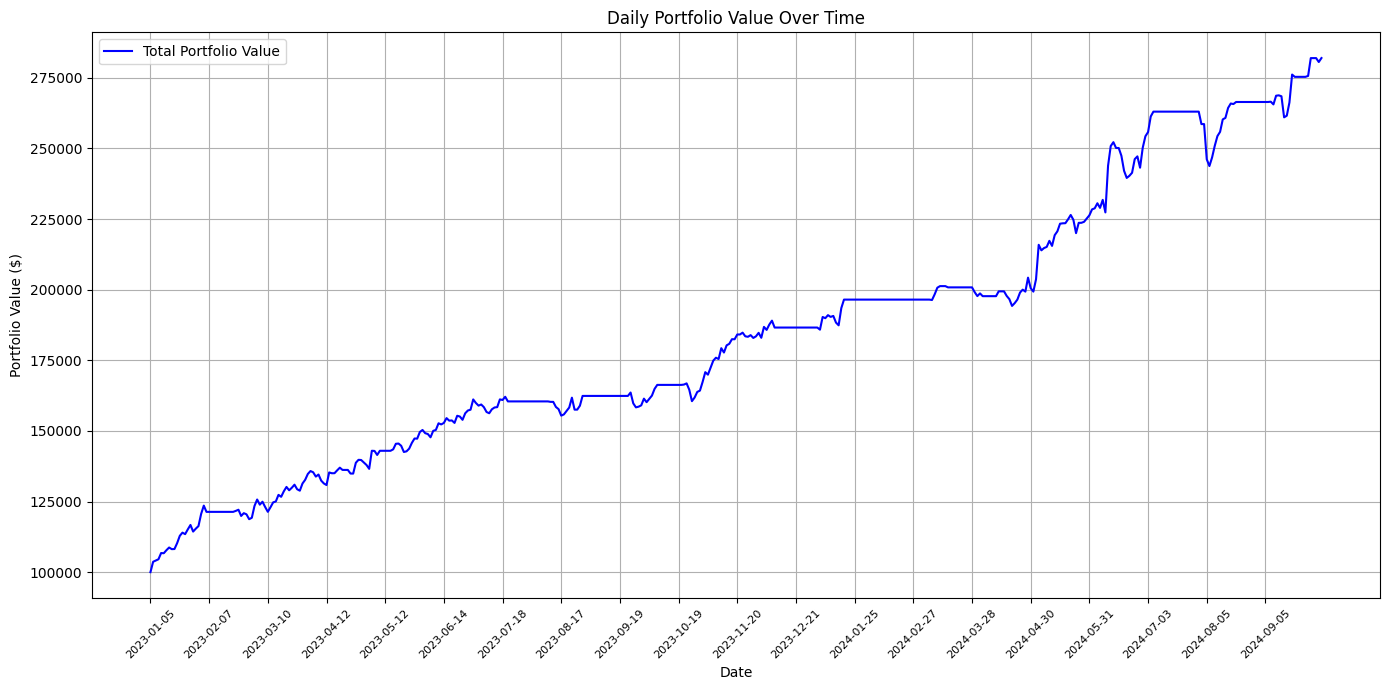


Initial Cash: $100000.00
Final Portfolio Value: $281972.63
Total Profit or Loss: $181972.63


In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the prediction dataset and original data
predictions = pd.read_csv("u14_predictions10.csv")
original_data = pd.read_csv("data.csv")

# Ensure both datasets have the same index for consistent calculations
predictions['timestamp'] = pd.to_datetime(predictions['Date'])
original_data['timestamp'] = pd.to_datetime(original_data['Date'])
merged = pd.merge(predictions[['timestamp', 'Predicted_BuyOrSell']], original_data[['timestamp', 'Close']], on='timestamp')
merged.sort_values(by='timestamp', inplace=True)

# Initial conditions
initial_cash = 100000.0
cash = initial_cash
stocks = 0

# DataFrame to track daily account changes
account_changes = []

# Simulate trading
for index, row in merged.iterrows():
    action = row['Predicted_BuyOrSell']
    price = row['Close']

    if action == 'buy' and cash >= price:
        # Buy as many stocks as we can afford with the available cash
        num_stocks_to_buy = cash // price
        cash -= num_stocks_to_buy * price
        stocks += num_stocks_to_buy
    elif action == 'sell' and stocks > 0:
        # Sell all stocks currently held
        cash += stocks * price
        stocks = 0

    # Record daily account value
    total_value = cash + (stocks * price)
    account_changes.append({'Date': row['timestamp'], 'Cash': cash, 'Stocks': stocks, 'Total Value': total_value})

    # Corrected print statement for daily account changes
    print(f"Date: {row['timestamp']}, Cash: {cash:.2f}, Stocks: {stocks}, Total Value: {total_value:.2f}")

# Create DataFrame from account changes
account_df = pd.DataFrame(account_changes)

# Format the Date for better readability
account_df['Date'] = account_df['Date'].dt.strftime('%Y-%m-%d')

# Print daily account changes with expanded date
print("\nDaily Account Changes:")
print(account_df)

# Plot daily account value changes with more x-axis ticks for better visibility
plt.figure(figsize=(14, 7))
plt.plot(account_df['Date'], account_df['Total Value'], label='Total Portfolio Value', color='blue')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Daily Portfolio Value Over Time')
plt.xticks(rotation=45, fontsize=8)  # Rotate the x-axis labels for better readability and expand tick size
plt.xticks(ticks=range(0, len(account_df), max(1, len(account_df) // 20)), rotation=45)  # Show more ticks, but not overcrowded
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final earnings calculation
final_value = account_df.iloc[-1]['Total Value']
profit_or_loss = final_value - initial_cash

# Print final earnings
print(f"\nInitial Cash: ${initial_cash:.2f}")
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Profit or Loss: ${profit_or_loss:.2f}")


# moving average for 12

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Loss: 0.1531769335269928, Validation Loss: 0.05717267841100693
Epoch 2, Loss: 0.10394446551799774, Validation Loss: 0.056421857327222824
Epoch 3, Loss: 0.039908431470394135, Validation Loss: 0.05175861343741417
Epoch 4, Loss: 0.0570414662361145, Validation Loss: 0.038343582302331924
Epoch 5, Loss: 0.007349079474806786, Validation Loss: 0.001496605109423399
Epoch 6, Loss: 0.0034483270719647408, Validation Loss: 0.0014205804327502847
Epoch 7, Loss: 0.0028572871815413237, Validation Loss: 0.0028994898311793804
current patience: 1
Epoch 8, Loss: 0.003835542593151331, Validation Loss: 0.0015099745942279696
current patience: 2
Epoch 9, Loss: 0.0023547883611172438, Validation Loss: 0.0012035073013976216
Epoch 10, Loss: 0.00022978124616201967, Validation Loss: 0.0007291713263839483
Epoch 11, Loss: 0.00030486617470160127, Validation Loss: 0.0004677330143749714
Epoch 12, Loss: 0.000291096861474216, Validation Loss: 0.0003952508850488812
Epoch 13, Loss: 0.00048270306433551013, Validation

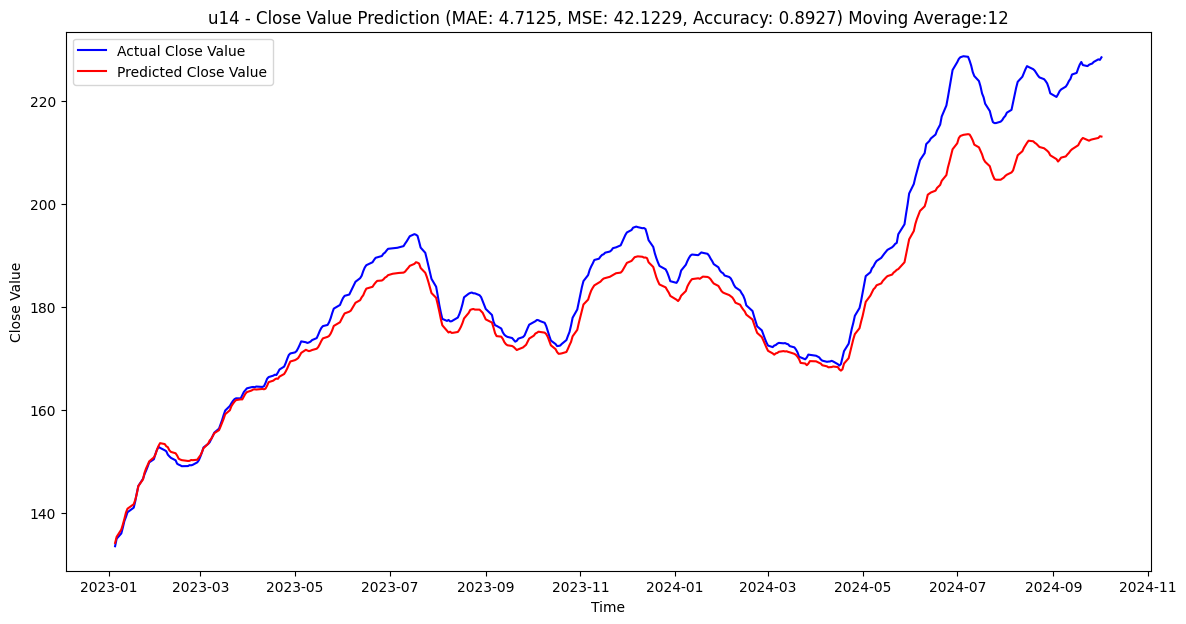

Predictions saved to u14_predictions12.csv
d142 - MAE: 0.7448, MSE: 3.3512
d142 - Buy/Sell Accuracy: 0.8877


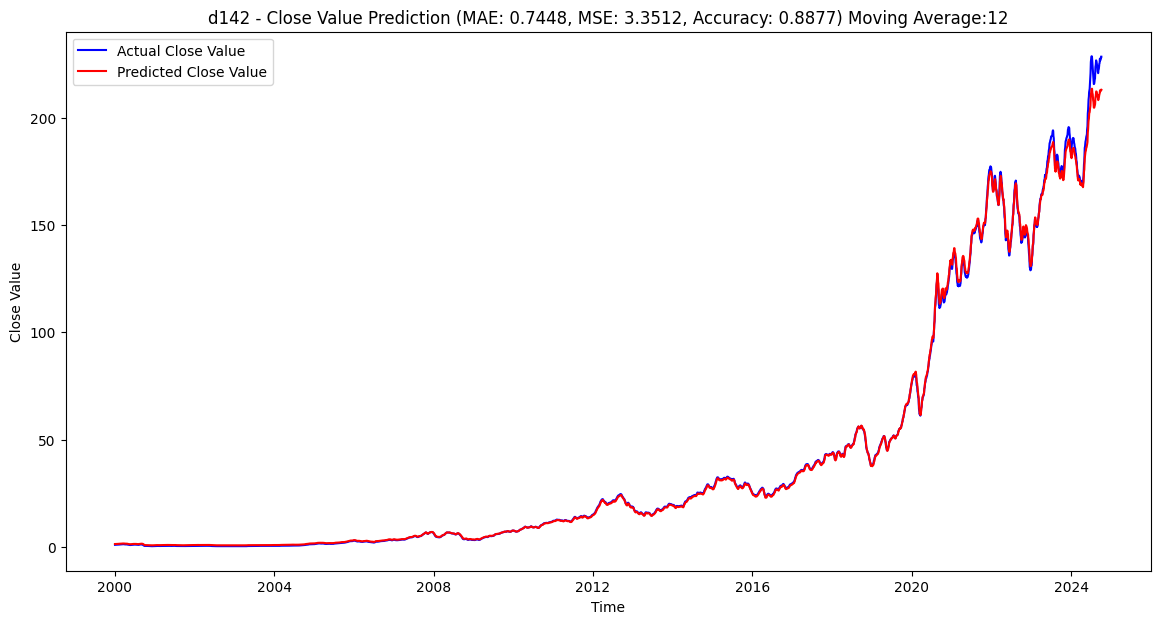

Predictions saved to d142_predictions12.csv


In [32]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Load the training dataset
data = pd.read_csv('train.csv')

# Use only 'Close' column as the target and features for LSTM model
data['timestamp'] = pd.to_datetime(data['Date'])
data.set_index('timestamp', inplace=True)
data.sort_index(inplace=True)
close_prices = data[['Close']]

# Apply moving average to denoise the data
window_ma = 12
close_prices_denoised = close_prices.rolling(window=window_ma).mean().dropna()

# Normalizing the training data
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(close_prices_denoised)
data_scaled_df = pd.DataFrame(scaled_values, columns=close_prices_denoised.columns, index=close_prices_denoised.index)

# Sequence function
def create_sequence(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i - window_size:i].values)
        y.append(data.iloc[i]['Close'])
    return np.array(X), np.array(y)

# Create sequences for training
window_size = 1
X, y = create_sequence(data_scaled_df, window_size)

# Split data (randomly)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Make y a column vector
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Load data in batches
batch_size = 512
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=1, num_layers=4):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

input_dim = X_train.shape[2]
model = LSTMModel(input_dim=input_dim, output_dim=1).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler for adaptive learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training with early stopping
num_epochs = 100
early_stop_patience = 10
best_loss = float('inf')
patience = 0
best_model = None

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test.to(device))
        val_loss = criterion(val_outputs, y_test.to(device))

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

    # Step the scheduler with the validation loss
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience = 0
        best_model = model.state_dict()
    else:
        patience += 1
        print("current patience:", patience)

        if patience >= early_stop_patience:
            print("Early stopping")
            break

# Load the best model
model.load_state_dict(best_model)

# Function to predict, evaluate, plot, and save to CSV
def predict_evaluate_plot_save(undata_filename, model, scaler, window_size, title_prefix):
    # Load the prediction dataset
    undata = pd.read_csv(undata_filename)
    undata['timestamp'] = pd.to_datetime(undata['Date'])
    undata.set_index('timestamp', inplace=True)
    undata.sort_index(inplace=True)
    close_prices_undata = undata[['Close']]

    # Apply moving average to denoise the prediction dataset
    close_prices_undata_denoised = close_prices_undata.rolling(window=window_ma).mean().dropna()

    # Normalizing the prediction dataset
    scaled_values_undata = scaler.transform(close_prices_undata_denoised)
    undata_scaled_df = pd.DataFrame(scaled_values_undata, columns=close_prices_undata_denoised.columns, index=close_prices_undata_denoised.index)

    # Create sequences for prediction
    X_undata, y_undata = create_sequence(undata_scaled_df, window_size)
    X_undata = torch.tensor(X_undata, dtype=torch.float32).to(device)

    # Predictions for the new dataset
    model.eval()
    with torch.no_grad():
        predictions_undata = model(X_undata).cpu().numpy()

    # Inverse transform the predictions and actual values
    y_undata_combined = np.concatenate((y_undata.reshape(-1, 1), np.zeros((y_undata.shape[0], undata_scaled_df.shape[1] - 1))), axis=1)
    y_undata_rescaled = scaler.inverse_transform(y_undata_combined)[:, 0]

    predictions_undata_combined = np.concatenate((predictions_undata, np.zeros((predictions_undata.shape[0], undata_scaled_df.shape[1] - 1))), axis=1)
    predictions_undata_rescaled = scaler.inverse_transform(predictions_undata_combined)[:, 0]

    # Ensure lengths match for plotting and saving
    min_length = min(len(y_undata_rescaled), len(predictions_undata_rescaled))
    y_undata_rescaled = y_undata_rescaled[:min_length]
    predictions_undata_rescaled = predictions_undata_rescaled[:min_length]

    # Calculate MAE and MSE
    mae_undata = mean_absolute_error(y_undata_rescaled, predictions_undata_rescaled)
    mse_undata = mean_squared_error(y_undata_rescaled, predictions_undata_rescaled)
    print(f"{title_prefix} - MAE: {mae_undata:.4f}, MSE: {mse_undata:.4f}")

    # Create 'buyorsell' labels based on predicted price movements
    actual_buyorsell = []
    predicted_buyorsell = []
    for i in range(len(predictions_undata_rescaled) - 1):
        if y_undata_rescaled[i+1] > y_undata_rescaled[i]:
            actual_buyorsell.append('buy')
        else:
            actual_buyorsell.append('sell')

        if predictions_undata_rescaled[i+1] > predictions_undata_rescaled[i]:
            predicted_buyorsell.append('buy')
        else:
            predicted_buyorsell.append('sell')

    # Assign the last label for buy/sell to avoid exceeding range
    actual_buyorsell.append('buy' if y_undata_rescaled[-1] > y_undata_rescaled[-2] else 'sell')
    predicted_buyorsell.append('buy' if predictions_undata_rescaled[-1] > predictions_undata_rescaled[-2] else 'sell')

    # Calculate accuracy of 'buyorsell' predictions
    actual_buyorsell = np.array(actual_buyorsell)
    predicted_buyorsell = np.array(predicted_buyorsell)
    accuracy = accuracy_score(actual_buyorsell, predicted_buyorsell)
    print(f"{title_prefix} - Buy/Sell Accuracy: {accuracy:.4f}")

    # Plot
    plt.figure(figsize=(14, 7))
    plt.plot(undata.index[window_size:window_size + min_length], y_undata_rescaled, color='blue', label='Actual Close Value')
    plt.plot(undata.index[window_size:window_size + min_length], predictions_undata_rescaled, color='red', label='Predicted Close Value')
    plt.title(f'{title_prefix} - Close Value Prediction (MAE: {mae_undata:.4f}, MSE: {mse_undata:.4f}, Accuracy: {accuracy:.4f}) Moving Average:{window_ma}')
    plt.xlabel('Time')
    plt.ylabel('Close Value')
    plt.legend()
    plt.show()

    # Save the predicted results to CSV
    undata_result = undata.iloc[window_size:window_size + min_length].copy()  # Align lengths properly
    undata_result['Predicted_Close'] = predictions_undata_rescaled  # Assign predictions
    undata_result['Predicted_BuyOrSell'] = predicted_buyorsell  # Assign predicted buy/sell labels
    undata_result.to_csv(f"{title_prefix}_predictions{window_ma}.csv", index=True)
    print(f"Predictions saved to {title_prefix}_predictions{window_ma}.csv")

# Apply model to 'u14.csv'
predict_evaluate_plot_save('undata.csv', model, scaler, window_size, title_prefix='u14')

# Apply model to 'd142.csv'
predict_evaluate_plot_save('data.csv', model, scaler, window_size, title_prefix='d142')


Date: 2023-01-05 00:00:00, Cash: 9874.98, Stocks: 1, Total Value: 10000.00
Date: 2023-01-06 00:00:00, Cash: 9745.36, Stocks: 2, Total Value: 10004.60
Date: 2023-01-09 00:00:00, Cash: 9615.21, Stocks: 3, Total Value: 10005.66
Date: 2023-01-10 00:00:00, Cash: 9484.48, Stocks: 4, Total Value: 10007.40
Date: 2023-01-11 00:00:00, Cash: 9350.99, Stocks: 5, Total Value: 10018.44
Date: 2023-01-12 00:00:00, Cash: 9217.58, Stocks: 6, Total Value: 10018.04
Date: 2023-01-13 00:00:00, Cash: 9082.82, Stocks: 7, Total Value: 10026.14
Date: 2023-01-17 00:00:00, Cash: 8946.88, Stocks: 8, Total Value: 10034.40
Date: 2023-01-18 00:00:00, Cash: 8811.67, Stocks: 9, Total Value: 10028.56
Date: 2023-01-19 00:00:00, Cash: 8676.40, Stocks: 10, Total Value: 10029.10
Date: 2023-01-20 00:00:00, Cash: 8538.53, Stocks: 11, Total Value: 10055.10
Date: 2023-01-23 00:00:00, Cash: 8397.42, Stocks: 12, Total Value: 10090.74
Date: 2023-01-24 00:00:00, Cash: 8254.89, Stocks: 13, Total Value: 10107.78
Date: 2023-01-25 00:0

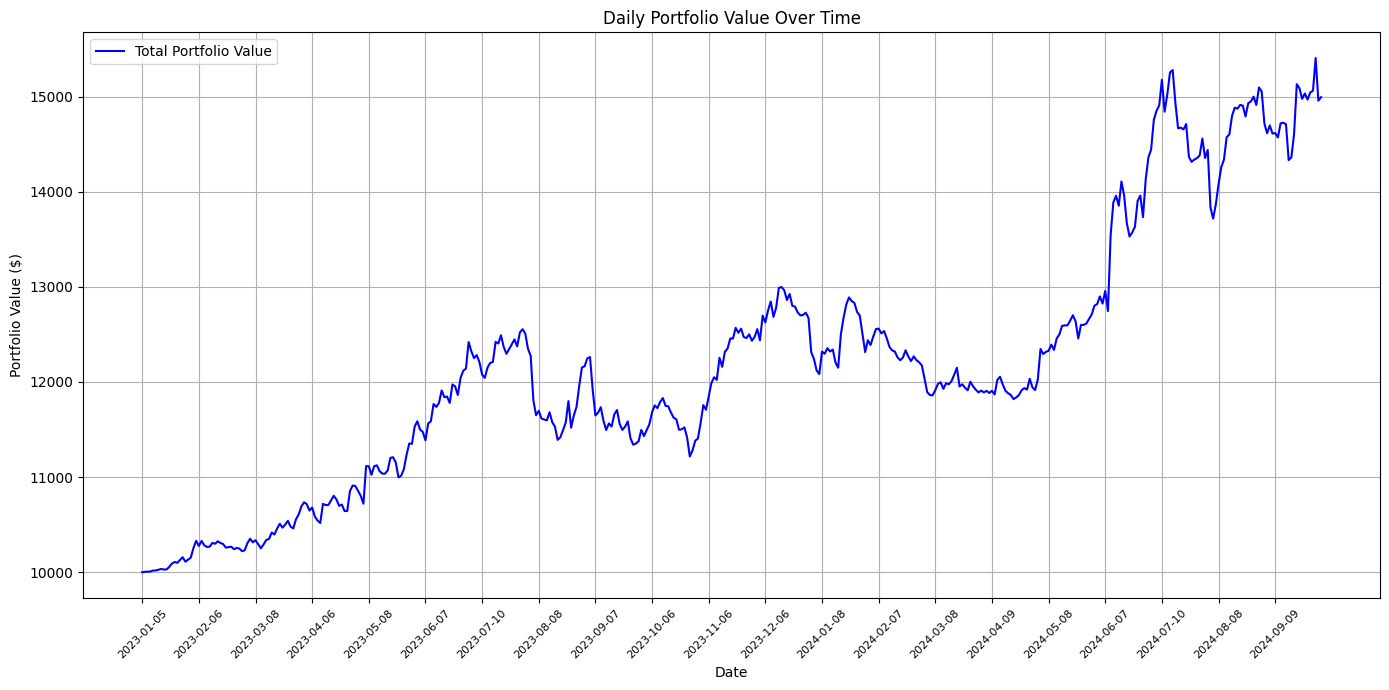


Initial Cash: $10000.00
Final Portfolio Value: $14994.59
Total Profit or Loss: $4994.59


In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the prediction dataset and original data
predictions = pd.read_csv("u14_predictions12.csv")
original_data = pd.read_csv("data.csv")

# Ensure both datasets have the same index for consistent calculations
predictions['timestamp'] = pd.to_datetime(predictions['Date'])
original_data['timestamp'] = pd.to_datetime(original_data['Date'])
merged = pd.merge(predictions[['timestamp', 'Predicted_BuyOrSell']], original_data[['timestamp', 'Close']], on='timestamp')
merged.sort_values(by='timestamp', inplace=True)

# Initial conditions
initial_cash = 10000.0
cash = initial_cash
stocks = 0

# DataFrame to track daily account changes
account_changes = []

# Simulate trading
for index, row in merged.iterrows():
    action = row['Predicted_BuyOrSell']
    price = row['Close']

    if action == 'buy' and cash >= price:
        # Buy 1 stock if we have enough cash
        cash -= price
        stocks += 1
    elif action == 'sell' and stocks > 0:
        # Sell 1 stock if we have any holdings
        cash += price
        stocks -= 1

    # Record daily account value
    total_value = cash + (stocks * price)
    account_changes.append({'Date': row['timestamp'], 'Cash': cash, 'Stocks': stocks, 'Total Value': total_value})

    # Corrected print statement for daily account changes
    print(f"Date: {row['timestamp']}, Cash: {cash:.2f}, Stocks: {stocks}, Total Value: {total_value:.2f}")

# Create DataFrame from account changes
account_df = pd.DataFrame(account_changes)

# Format the Date for better readability
account_df['Date'] = account_df['Date'].dt.strftime('%Y-%m-%d')

# Print daily account changes with expanded date
print("Daily Account Changes:")
print(account_df)

# Plot daily account value changes with more x-axis ticks for better visibility
plt.figure(figsize=(14, 7))
plt.plot(account_df['Date'], account_df['Total Value'], label='Total Portfolio Value', color='blue')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Daily Portfolio Value Over Time')
plt.xticks(rotation=45, fontsize=8)  # Rotate the x-axis labels for better readability and expand tick size
plt.xticks(ticks=range(0, len(account_df), max(1, len(account_df)//20)), rotation=45)  # Show more ticks, but not overcrowded
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final earnings calculation
final_value = account_df.iloc[-1]['Total Value']
profit_or_loss = final_value - initial_cash

# Print final earnings
print(f"\nInitial Cash: ${initial_cash:.2f}")
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Profit or Loss: ${profit_or_loss:.2f}")


Date: 2023-01-05 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 100000.00
Date: 2023-01-06 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 103675.40
Date: 2023-01-09 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 104098.87
Date: 2023-01-10 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 104562.29
Date: 2023-01-11 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 106767.54
Date: 2023-01-12 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 106703.62
Date: 2023-01-13 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 107782.26
Date: 2023-01-17 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 108725.08
Date: 2023-01-18 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 108141.82
Date: 2023-01-19 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 108189.76
Date: 2023-01-20 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 110267.15
Date: 2023-01-23 00:00:00, Cash: 109.02, Stocks: 799.0, Total Value: 112855.91
Date: 2023-01-24 00:00:00, Cash: 109.02, Stocks: 799

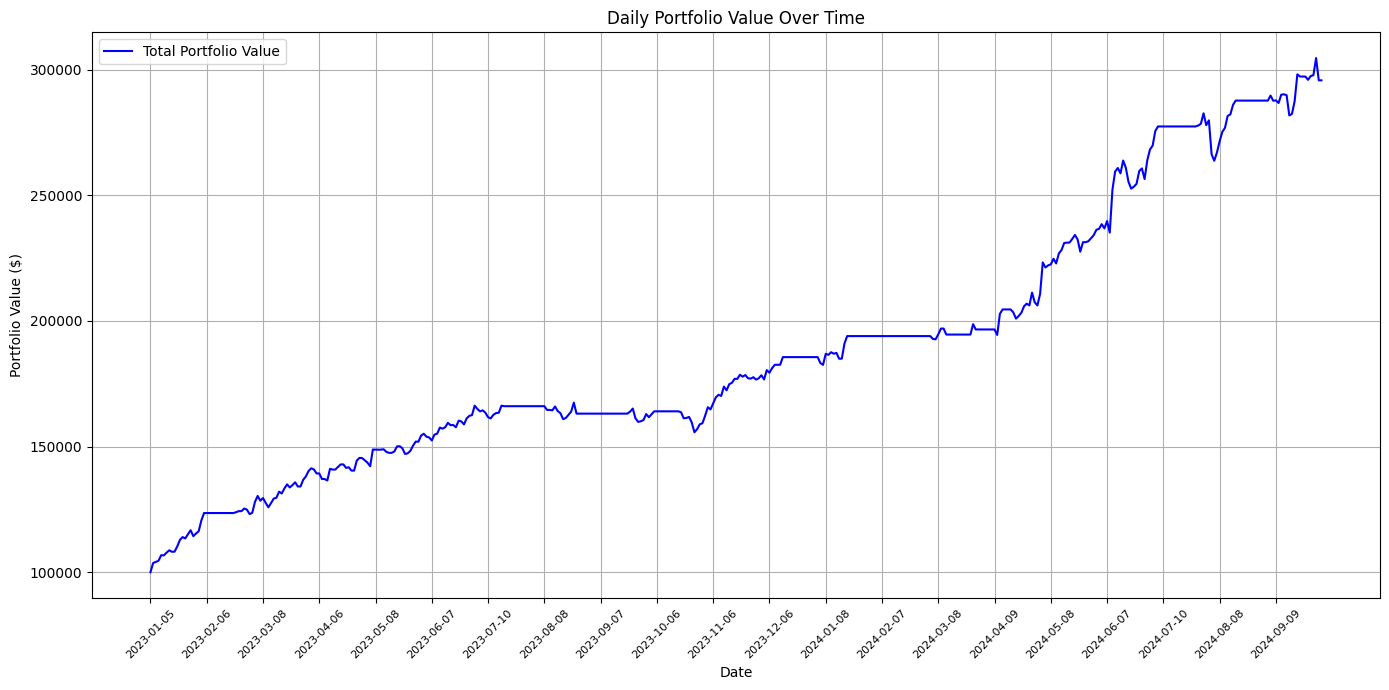


Initial Cash: $100000.00
Final Portfolio Value: $295706.06
Total Profit or Loss: $195706.06


In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the prediction dataset and original data
predictions = pd.read_csv("u14_predictions12.csv")
original_data = pd.read_csv("data.csv")

# Ensure both datasets have the same index for consistent calculations
predictions['timestamp'] = pd.to_datetime(predictions['Date'])
original_data['timestamp'] = pd.to_datetime(original_data['Date'])
merged = pd.merge(predictions[['timestamp', 'Predicted_BuyOrSell']], original_data[['timestamp', 'Close']], on='timestamp')
merged.sort_values(by='timestamp', inplace=True)

# Initial conditions
initial_cash = 100000.0
cash = initial_cash
stocks = 0

# DataFrame to track daily account changes
account_changes = []

# Simulate trading
for index, row in merged.iterrows():
    action = row['Predicted_BuyOrSell']
    price = row['Close']

    if action == 'buy' and cash >= price:
        # Buy as many stocks as we can afford with the available cash
        num_stocks_to_buy = cash // price
        cash -= num_stocks_to_buy * price
        stocks += num_stocks_to_buy
    elif action == 'sell' and stocks > 0:
        # Sell all stocks currently held
        cash += stocks * price
        stocks = 0

    # Record daily account value
    total_value = cash + (stocks * price)
    account_changes.append({'Date': row['timestamp'], 'Cash': cash, 'Stocks': stocks, 'Total Value': total_value})

    # Corrected print statement for daily account changes
    print(f"Date: {row['timestamp']}, Cash: {cash:.2f}, Stocks: {stocks}, Total Value: {total_value:.2f}")

# Create DataFrame from account changes
account_df = pd.DataFrame(account_changes)

# Format the Date for better readability
account_df['Date'] = account_df['Date'].dt.strftime('%Y-%m-%d')

# Print daily account changes with expanded date
print("\nDaily Account Changes:")
print(account_df)

# Plot daily account value changes with more x-axis ticks for better visibility
plt.figure(figsize=(14, 7))
plt.plot(account_df['Date'], account_df['Total Value'], label='Total Portfolio Value', color='blue')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Daily Portfolio Value Over Time')
plt.xticks(rotation=45, fontsize=8)  # Rotate the x-axis labels for better readability and expand tick size
plt.xticks(ticks=range(0, len(account_df), max(1, len(account_df) // 20)), rotation=45)  # Show more ticks, but not overcrowded
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final earnings calculation
final_value = account_df.iloc[-1]['Total Value']
profit_or_loss = final_value - initial_cash

# Print final earnings
print(f"\nInitial Cash: ${initial_cash:.2f}")
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Profit or Loss: ${profit_or_loss:.2f}")


# the conclusion is  conservative traing is more suitable for long moving average, but the all in type is more suitble for the short term moving average